# CSC/ECE 591 Metaheuristics for Search and Optimization Term Project: 
# Analysis and Julia Implementation of Genetic Algorithm Based on Natural Selection Theory for the Traveling Salesman Problem

#### Imports

In [57]:
# Run
using Distributions
using Distances
using Random
import PlotlyJS

# Debug
using DataStructures

# using Pkg
# Pkg.add("PrettyTables")
using PrettyTables

## Functions for Development and Testing

In [58]:
# Maximize the number of 1s in a binary vector, re-written as a minimization problem
maxone(x) = -sum(x)

maxone (generic function with 1 method)

In [59]:
# create m random binary vectors of length n
rand_population_binary(m, n) = [rand((0,1),n) for i in 1:m]

rand_population_binary (generic function with 1 method)

## Initialize Population

In [60]:
# Initialize Population
abstract type InitializeMethod end
struct BinaryPopulation <: InitializeMethod
    population_size
    chromosome_length
end
function init_population(p::BinaryPopulation)
    return [rand((0,1),p.chromosome_length) for i in 1:p.population_size]
end

init_population (generic function with 3 methods)

In [61]:
abstract type ReplacementMethod end

struct BinaryChromosome <: ReplacementMethod
    chromosome_length
end
function generate_chromosome(r::BinaryChromosome)
    return rand((0,1), r.chromosome_length)
end


generate_chromosome (generic function with 3 methods)

## Selection, Crossover, and Mutation methods

### Selection

In [62]:
abstract type SelectionMethod end

# Truncation Selection
# Pick a parent randomly from top k parents
struct SingleParentTruncationSelection <: SelectionMethod
    k # top k to keep
end
function select(t::SingleParentTruncationSelection, y)
    # println(y)
    p = sortperm(y)
    # println(p)
    # println(p[rand(1:t.k)])
    return p[rand(1:t.k)]
end

select (generic function with 1 method)

### Crossover

In [63]:
abstract type CrossoverMethod end
struct SinglePointCrossover <: CrossoverMethod end
function crossover(c::SinglePointCrossover, a, b)
    i = rand(1:length(a))
    return vcat(a[1:i], b[i+1:end])
end

struct TwoPointCrossover <: CrossoverMethod end
function crossover(c::TwoPointCrossover, a, b)
    n = length(a)
    i, j = rand(1:n, 2)
    if i > j
        (i,j) = (j,i)
    end
    return vcat(a[1:i], b[i+1:j], a[j+1:n])
end

crossover (generic function with 4 methods)

### Mutation

In [64]:
abstract type MutationMethod end
struct BitwiseMutation <: MutationMethod
    λ
end

#function mutate(M::BitwiseMutation, child)
#    return [rand() < M.λ ? !v : v for v in child]
#end

function mutate(M::BitwiseMutation, child)
    return [rand() < M.λ ? abs(v-1) : v for v in child]
end


mutate (generic function with 5 methods)

## Genetic Algorithm Based on Natural Selection Theorem
### Fitness Function Minimization

In [65]:
# Genetic Algorithm Based on Natural Selection Theorem (minimizing fitness function)
function GABONST(g, population, max_iter, S, C, M, R, path_record, avg_fitness_record, best_fitness_record, current_best_record)
    
    # g : Fitness Function
    # population : Initial Population
    # max_iter : Number of generations to run
    # S : Selection method
    # C : Crossover method
    # M : Mutation method
    # R : Replacement method
    # path_record : array to keep track of decision paths
    # avg_fitness_record : array to keep track of average population fitness
    # best_fitness_record : array to keep track of global best fitness
    # current_best_record : array to keep track of generational best fitness
    
    # vector of fitness score of each individual
    current_fitnesses = g.(population)

    # mean fitness of the population
    mean_fitness = mean(current_fitnesses)
    push!(avg_fitness_record, mean_fitness)
    
    # initialize best individual
    current_best_individual = population[argmin(current_fitnesses)]
    global_best_individual = copy(current_best_individual)
    push!(best_fitness_record, g(current_best_individual))
    push!(current_best_record, g(current_best_individual))
    
    for iter in 1:max_iter
        # empty vector to store the population of next generation
        next_generation = []
        
        # record stats of current generation
        path = []
        #### RECORD RUN
        for individual in population
            if g(individual) <= mean_fitness
                # mutate individual and add to next generation
                push!(next_generation, mutate(M, individual))
                push!(path, "A")
            else
                # crossover with one of the top individuals
                elite_parent = select(S, current_fitnesses)
                
                crossed_individual = crossover(C, individual, population[elite_parent])
                #crossed_individual = crossover(C, population[elite_parent], individual)
                
                if g(crossed_individual) <= mean_fitness
                    # add to next generation
                    push!(next_generation, crossed_individual)
                    push!(path, "B")
                    
                else
                    # mutate individual
                    crossed_and_mutated_individual = mutate(M, crossed_individual)
                    
                    if g(crossed_and_mutated_individual) <= mean_fitness
                        # add to next generation
                        push!(next_generation, crossed_and_mutated_individual)
                        push!(path, "C")
                        
                    else
                        # randomly generate a individual and add that to next generation
                        push!(next_generation, generate_chromosome(R))
                        push!(path, "D")
                        
                    end
                end
            end
        end
        # update vector of fitness score of each individual
        current_fitnesses = g.(population)

        # update mean fitness of the population
        mean_fitness = mean(current_fitnesses)
        
        # update the best individual across history
        current_best_individual = population[argmin(current_fitnesses)]
        
        if g(current_best_individual) < g(global_best_individual)
            global_best_individual = copy(current_best_individual)
        end
        
        # replace current population with next generation
        population = copy(next_generation)
        
        # record path
        push!(path_record, copy(path))
        push!(best_fitness_record, g(global_best_individual))
        push!(avg_fitness_record, mean_fitness)
        push!(current_best_record, g(current_best_individual))
        
    end
    # report current population and the best individual of the current population
    return global_best_individual, population
end

GABONST (generic function with 1 method)

#### With Max One Function

In [66]:
# set random seed for reproducible results
Random.seed!(314159)

# set fitness function g(S)
fitness_function(x) = maxone(x)

# set maximum iteration
max_iteration = 1000

# set population parameters
pop_size = 50
chromosome_length = 38

# initialize population
I = BinaryPopulation(pop_size, chromosome_length)
population = init_population(I)

# set replacement method for individual
R = BinaryChromosome(chromosome_length)

# set selection, crossover, and mutation methods
S = SingleParentTruncationSelection(5)
C = TwoPointCrossover()
M = BitwiseMutation(0.001)

# init path record
path_record = []
avg_record = []
global_record = []
current_best_record = []

# run GABONST
best_individual, population = GABONST(fitness_function, population, max_iteration, S, C, M, R, path_record, avg_record, global_record, current_best_record)

println(best_individual)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


#### Convergence Plot

In [67]:
using PlotlyJS
n = length(global_record)
iter = 1:n
# plot(iter, [avg_record, global_record, current_best_record])

plot([
    scatter(x=iter, y=avg_record, mode="lines", name="Average Scores"),
    scatter(x=iter, y=global_record, mode="lines", name="Global Best Scores"),
    scatter(x=iter, y=current_best_record, mode="lines", name="Generation Best Scores")
    ], 
    Layout(yaxis_title="Cost", xaxis_title="Generations", title="GABONST Performance"))

data: [
  "scatter with fields mode, name, type, x, and y",
  "scatter with fields mode, name, type, x, and y",
  "scatter with fields mode, name, type, x, and y"
]

layout: "layout with fields margin, template, title, xaxis, and yaxis"

#### Function to track decision paths taken by algorithm

In [15]:
function path_stat(path_record)
    stat_record = []
    for record in path_record
        c = counter(record)
        push!(stat_record, c)
    end
    return stat_record
end

path_stat (generic function with 1 method)

In [16]:
stat_record = path_stat(path_record)
for record in stat_record
    println(record)
end

Accumulator(B => 10, A => 27, D => 13)
Accumulator(B => 5, A => 40, D => 5)
Accumulator(B => 13, A => 31, D => 6)
Accumulator(B => 12, A => 31, D => 7)
Accumulator(B => 3, A => 46, D => 1)
Accumulator(B => 12, A => 31, D => 7)
Accumulator(B => 15, A => 19, D => 16)
Accumulator(B => 5, A => 36, D => 9)
Accumulator(B => 1, A => 40, D => 9)
Accumulator(B => 2, A => 41, D => 7)
Accumulator(B => 1, A => 44, D => 5)
Accumulator(B => 9, A => 25, D => 16)
Accumulator(B => 2, A => 36, D => 12)
Accumulator(B => 2, A => 39, C => 1, D => 8)
Accumulator(B => 5, A => 40, D => 5)
Accumulator(B => 1, A => 45, D => 4)
Accumulator(B => 15, A => 24, D => 11)
Accumulator(B => 2, A => 39, D => 9)
Accumulator(B => 1, A => 41, D => 8)
Accumulator(B => 2, A => 42, D => 6)
Accumulator(B => 2, A => 44, D => 4)
Accumulator(A => 46, D => 4)
Accumulator(B => 11, A => 23, D => 16)
Accumulator(B => 5, A => 34, D => 11)
Accumulator(B => 3, A => 39, D => 8)
Accumulator(A => 42, D => 8)
Accumulator(B => 2, A => 40, D =

Accumulator(A => 44, D => 6)
Accumulator(B => 1, A => 44, D => 5)
Accumulator(A => 45, D => 5)
Accumulator(A => 45, D => 5)
Accumulator(B => 1, A => 44, D => 5)
Accumulator(A => 45, D => 5)
Accumulator(A => 45, D => 5)
Accumulator(B => 1, A => 45, D => 4)
Accumulator(B => 1, A => 45, D => 4)
Accumulator(B => 1, A => 46, D => 3)
Accumulator(B => 8, A => 32, D => 10)
Accumulator(A => 40, D => 10)
Accumulator(A => 40, D => 10)
Accumulator(B => 1, A => 40, D => 9)
Accumulator(A => 41, D => 9)
Accumulator(A => 41, D => 9)
Accumulator(A => 41, D => 9)
Accumulator(A => 41, D => 9)
Accumulator(A => 41, D => 9)
Accumulator(B => 2, A => 41, D => 7)
Accumulator(B => 1, A => 43, D => 6)
Accumulator(A => 44, D => 6)
Accumulator(B => 5, A => 40, D => 5)
Accumulator(B => 1, A => 44, D => 5)
Accumulator(B => 1, A => 45, D => 4)
Accumulator(B => 1, A => 44, D => 5)
Accumulator(B => 1, A => 45, D => 4)
Accumulator(A => 46, D => 4)
Accumulator(B => 5, A => 34, D => 11)
Accumulator(A => 39, D => 11)
Accum

Accumulator(A => 44, D => 6)
Accumulator(A => 44, D => 6)
Accumulator(A => 44, D => 6)
Accumulator(A => 44, D => 6)
Accumulator(A => 43, D => 7)
Accumulator(A => 42, D => 8)
Accumulator(A => 42, D => 8)
Accumulator(B => 1, A => 42, D => 7)
Accumulator(B => 1, A => 43, D => 6)
Accumulator(A => 43, D => 7)
Accumulator(B => 2, A => 43, D => 5)
Accumulator(A => 45, D => 5)
Accumulator(B => 1, A => 43, D => 6)
Accumulator(A => 44, D => 6)
Accumulator(A => 44, D => 6)
Accumulator(A => 44, D => 6)
Accumulator(A => 44, D => 6)
Accumulator(A => 44, D => 6)
Accumulator(A => 42, D => 8)
Accumulator(A => 42, D => 8)
Accumulator(A => 42, D => 8)
Accumulator(B => 1, A => 42, D => 7)
Accumulator(B => 1, A => 43, D => 6)
Accumulator(B => 1, A => 44, D => 5)
Accumulator(B => 1, A => 43, D => 6)
Accumulator(A => 44, D => 6)
Accumulator(B => 1, A => 44, D => 5)
Accumulator(B => 2, A => 44, D => 4)
Accumulator(A => 46, D => 4)
Accumulator(A => 46, D => 4)
Accumulator(A => 46, D => 4)
Accumulator(A => 45, 

### Fitness Function Minimization
#### Optimizing Real Numbers

#### Objective functions from the GABONST paper

In [68]:
# Paper uses 10 dimensions and the function is defined over [-1, 1], optimal solution = -1
f_1(x) = -mean(sin.(5*π.*x).^6)
f_1(x, y) = -0.5*(sin(5*π*x)^6 + sin(5*π*y)^6)

f_1 (generic function with 2 methods)

In [ ]:
# data for 3d surface plot
x=-1:0.01:1
y=-1:0.01:1
z = f_1.(x',y)

layout = PlotlyJS.Layout(title="3d Surface Plot of the f_1 Function")
PlotlyJS.plot(PlotlyJS.surface(x=x,y=y,z=z), layout)

In [69]:
# Paper uses 2 dimensions and the function is defined over [0, π], optimal solution = -1.8013
f_2(x, y) = -((sin(x)*sin((x^2)/π)*sin((x^2)/π)) + (sin(y)*sin((2*(y^2))/π)*sin((2*(y^2))/π)))
f_2(x) = -((sin(x[1])*sin((x[1]^2)/π)*sin((x[1]^2)/π)) + (sin(x[2])*sin((2*(x[2]^2))/π)*sin((2*(x[2]^2))/π)))

f_2 (generic function with 2 methods)

In [ ]:
# data for 3d surface plot
x=0:0.01:π
y=0:0.01:π
z = f_2.(x',y)

layout = PlotlyJS.Layout(title="3d Surface Plot of the f_2 Function")
PlotlyJS.plot(PlotlyJS.surface(x=x,y=y,z=z), layout)

In [70]:
# Paper uses 2 dimensions and the function is defined over [10, 10], optimal solution = 0
f_3(x, y) = (x + 2*y − 7)^2 + (2*x + y − 5)^2
f_3(x) = (x[1] + 2*x[2] − 7)^2 + (2*x[1] + x[2] − 5)^2

f_3 (generic function with 2 methods)

In [ ]:
# data for 3d surface plot
x=-10:0.1:10
y=-10:0.1:10
z = f_3.(x',y)

layout = PlotlyJS.Layout(title="3d Surface Plot of the f_3 Function")
PlotlyJS.plot(PlotlyJS.surface(x=x,y=y,z=z), layout)

In [71]:
# Paper uses 10 dimensions and the function is defined over [-5, 5], optimal solution = −391.6599
f_4(x, y) = 0.5*((x^4 - 16*(x^2) + 5*x) + (y^4 - 16*(y^2) + 5*y))
f_4(x) = 0.5 * sum(x.^4 - 16 * (x.^2) + 5*x)

f_4 (generic function with 2 methods)

In [ ]:
# data for 3d surface plot
x=-5:0.1:5
y=-5:0.1:5
z = f_4.(x',y)

layout = PlotlyJS.Layout(title="3d Surface Plot of the f_4 Function")
PlotlyJS.plot(PlotlyJS.surface(x=x,y=y,z=z), layout)

In [72]:
# Paper uses 2 dimensions and the function is defined over [0, 10], optimal solution = −6.1295
f_5(x, y) = (sqrt(x) * sin(x)) * (sqrt(y) * sin(y))
f_5(x) = (sqrt(x[1]) * sin(x[1])) * (sqrt(x[2]) * sin(x[2]))

f_5 (generic function with 2 methods)

In [ ]:
# data for 3d surface plot
x=0:0.1:10
y=0:0.1:10
z = f_5.(x',y)

layout = PlotlyJS.Layout(title="3d Surface Plot of the f_5 Function")
PlotlyJS.plot(PlotlyJS.surface(x=x,y=y,z=z), layout)

In [73]:
# Paper uses 256 dimensions and the function is defined over [-5.12, 5.12], optimal solution = 0
f_6(x, y) = x^2 + y^2
f_6(x) = sum(x.^2)

f_6 (generic function with 2 methods)

In [ ]:
# data for 3d surface plot
x=-5.12:0.1:5.12
y=-5.12:0.1:5.12
z = f_6.(x',y)


layout = PlotlyJS.Layout(title="3d Surface Plot of the f_6 Function")
PlotlyJS.plot(PlotlyJS.surface(x=x,y=y,z=z), layout)

In [74]:
# Paper uses 30 dimensions and the function is defined over [-30, 30], optimal solution = 0

function f_7(x)
    cost = 0.0
    for i in 1: (length(x)-1)
        cost += ((100*(x[i+1] - (x[i]^2))^2) + (x[i] - 1)^2)
    end
    return cost
end
f_7(x, y) = (100 * (y - (x^2))^2) + (x - 1)^2

f_7 (generic function with 2 methods)

In [ ]:
# data for 3d surface plot
x=-30:0.1:30
y=-30:0.1:30
z = f_7.(x',y)

layout = PlotlyJS.Layout(title="3d Surface Plot of the f_7 Function")
PlotlyJS.plot(PlotlyJS.surface(x=x,y=y,z=z), layout)

In [75]:
# Paper uses 30 dimensions and the function is defined over [-1.28, 1.28], optimal solution = 0

function f_8(x)
    cost = 0.0
    for i in 1: length(x)
        cost += (i * (x[i]^4))
    end
    return cost + rand()
end
f_8(x, y) = x^4 + 2*y^4 + rand()

f_8 (generic function with 2 methods)

In [ ]:
# data for 3d surface plot
x=-1.28:0.01:1.28
y=-1.28:0.01:1.28
z = f_8.(x',y)

layout = PlotlyJS.Layout(title="3d Surface Plot of the f_8 Function")
PlotlyJS.plot(PlotlyJS.surface(x=x,y=y,z=z), layout)

In [76]:
# Paper uses 30 dimensions and the function is defined over [-5.12, 5.12], optimal solution = 0

f_9(x) = sum((x.^2) - (10 * cos.(2*π*x)) .+ 10)
f_9(x, y) = x^2 - (10 * cos(2*π*x)) + 10 + y^2 - (10 * cos(2*π*y)) + 10

f_9 (generic function with 2 methods)

In [ ]:
# data for 3d surface plot
x=-5.12:0.1:5.12
y=-5.12:0.1:5.12
z = f_9.(x',y)

layout = PlotlyJS.Layout(title="3d Surface Plot of the f_9 Function")
PlotlyJS.plot(PlotlyJS.surface(x=x,y=y,z=z), layout)

In [77]:
# Paper uses 128 dimensions and the function is defined over  [−32.768, 32.768], optimal solution = 0

f_10(x) = (-20 * (ℯ ^ (-0.2*(sqrt(mean((x.^2))))))) - (ℯ^(mean(cos.(2*π*x)))) + 20 + ℯ
f_10(x, y) = (-20 * (ℯ ^ (-0.2*(sqrt(0.5*(x^2 + y^2)))))) - (ℯ^(0.5*(cos(2*π*x)+cos(2*π*y)))) + 20 + ℯ

f_10 (generic function with 2 methods)

In [ ]:
# data for 3d surface plot
x=-32.768:0.1:32.768
y=-32.768:0.1:32.768
z = f_10.(x',y)

layout = PlotlyJS.Layout(title="3d Surface Plot of the f_10 Function")
PlotlyJS.plot(PlotlyJS.surface(x=x,y=y,z=z), layout)

In [78]:
# Paper uses 30 dimensions and the function is defined over  [−600, 600], optimal solution = 0

function f_11(x)
    cost_first = ((1/4000)*sum(x.^2))
    cost_second = 1
    for i in 1:length(x)
        cost_second *= cos((x[i]/sqrt(i)))
    end
    return cost_first - cost_second + 1
end

f_11(x, y) = ((1/4000)*(x^2 + y^2)) - (cos(x) * cos(y/sqrt(2))) + 1

f_11 (generic function with 2 methods)

In [ ]:
# data for 3d surface plot
x=-600:1:600
y=-600:1:600
z = f_11.(x',y)

layout = PlotlyJS.Layout(title="3d Surface Plot of the f_11 Function")
PlotlyJS.plot(PlotlyJS.surface(x=x,y=y,z=z), layout)

In [79]:
# Paper uses 2 dimensions and the function is defined over  [−2, 2], optimal solution = 3


f_12(x, y) = (1 + (((x + y + 1)^2) * (19 - 14*x + 3*(x^2) - 14*y + 6*x*y + 3*(y^2)))) * (30 + (((2*x - 3*y)^2) * (18 - 32*x + 12*(x^2) + 48*y -36*x*y +27*(y^2))))

f_12(x) = (1 + (((x[1] + x[2] + 1)^2) * (19 - 14*x[1] + 3*(x[1]^2) - 14*x[2] + 6*x[1]*x[2] + 3*(x[2]^2)))) * (30 + (((2*x[1] - 3*x[2])^2) * (18 - 32*x[1] + 12*(x[1]^2) + 48*x[2] -36*x[1]*x[2] +27*(x[2]^2))))

f_12 (generic function with 2 methods)

In [ ]:
# data for 3d surface plot
x=-2:0.1:2
y=-2:0.1:2
z = f_12.(x',y)

layout = PlotlyJS.Layout(title="3d Surface Plot of the f_12 Function")
PlotlyJS.plot(PlotlyJS.surface(x=x,y=y,z=z), layout)

In [80]:
# We ignore function f_13 since there are unknown values ai and bi in the equation?

In [81]:
# Paper uses 2 dimensions and the function is defined over  [−5, 5], optimal solution = -1.0316

f_14(x) = 4*(x[1]^2) - 2.1*(x[1]^4) + (1/3)*(x[1]^6) + x[1]*x[2] - 4*(x[2]^2) + 4*(x[2]^4)
f_14(x, y) = 4*(x^2) - 2.1*(x^4) + (1/3)*(x^6) + x*y - 4*(y^2) + 4*(y^4)

f_14 (generic function with 2 methods)

In [ ]:
# data for 3d surface plot
x=-5:0.01:5
y=-5:0.01:5
z = f_14.(x',y)


layout = PlotlyJS.Layout(title="3d Surface Plot of the f_14 Function")
PlotlyJS.plot(PlotlyJS.surface(x=x,y=y,z=z), layout)

In [82]:
# Paper uses 2 dimensions and the function is defined over  [−5, 5], optimal solution = 0.398

f_15(x) = (x[2] - (5.1/(4*(π^2)))*(x[1]^2) + (5/π)*x[1] - 6)^2 + (10*(1 - (1/(8*π)))*cos(x[1])) + 10
f_15(x, y) = (y - (5.1/(4*(π^2)))*(x^2) + (5/π)*x - 6)^2 + (10*(1 - (1/(8*π)))*cos(x)) + 10

f_15 (generic function with 2 methods)

In [ ]:
# data for 3d surface plot
x=-5:0.01:5
y=-5:0.01:5
z = f_15.(x',y)

layout = PlotlyJS.Layout(title="3d Surface Plot of the f_15 Function")
PlotlyJS.plot(PlotlyJS.surface(x=x,y=y,z=z), layout)

#### Population Initialization, Crossover and Mutation for Real Number Optimization

In [83]:
# New init method for real numbers
struct RealNumberVecPopulation <: InitializeMethod
    population_size
    chromosome_length
    upper_bound
    lower_bound
end
function init_population(p::RealNumberVecPopulation)
    return [rand(Uniform(lower_bound,upper_bound),p.chromosome_length) for i in 1:p.population_size]
end

# New replacement method for real numbers
struct RealNumberChromosome <: ReplacementMethod
    chromosome_length
    upper_bound
    lower_bound
end
function generate_chromosome(r::RealNumberChromosome)
    return rand(Uniform(r.lower_bound, r.upper_bound), r.chromosome_length)
end

# Arithmetic Crossover from the original paper
struct ArithmeticCrossover <: CrossoverMethod
    gamma
    upper_bound
    lower_bound
end
function crossover(c::ArithmeticCrossover, a, b)
    n = length(a)
    alpha = rand(Uniform(-gamma,1+gamma),n)
    offspring = (alpha.*a) + ((-alpha.+1).*b)
    clamp!(offspring, lower_bound, upper_bound)
    return offspring
end

# Real number mutation
struct UniformMutation <: MutationMethod
    λ
    upper_bound
    lower_bound
end

function mutate(M::UniformMutation, child)
    return [(rand() < M.λ) ? rand(Uniform(lower_bound, upper_bound)) : v for v in child ]
end

struct GaussianMutation <: MutationMethod
    σ
end

function mutate(M::GaussianMutation, child)
    return child + randn(length(child))*M.σ
end

mutate (generic function with 5 methods)

#### Test run on one of the objective functions

In [84]:
# set random seed for reproducible results
Random.seed!(27)

# set fitness function g(S)
fitness_function(x)=f_9(x)

#set bound
upper_bound = 5.12
lower_bound = -5.12

# set maximum iteration
max_iteration = 100

# set population parameters
pop_size = 50
chromosome_length = 30

gamma = 0.4
mutation_rate = 0.01

# initialize population
I = RealNumberVecPopulation(pop_size, chromosome_length, upper_bound, lower_bound)
population = init_population(I)


# set replacement method for individual
R = RealNumberChromosome(chromosome_length, upper_bound, lower_bound)

# set selection, crossover, and mutation methods
S = SingleParentTruncationSelection(5)
C = ArithmeticCrossover(gamma, upper_bound, lower_bound)
#C = TwoPointCrossover()
M = UniformMutation(mutation_rate, upper_bound, lower_bound)
#M = GaussianMutation(1)
# init path record
path_record = []
avg_record = []
global_record = []
current_best_record = []

# run GABONST
best_individual, population = GABONST(fitness_function, population, max_iteration, S, C, M, R, path_record, avg_record, global_record, current_best_record) 


println(fitness_function(best_individual))
    

288.1607604261926


#### Convergence Plot

In [85]:
using PlotlyJS
n = length(global_record)
iter = 1:n

plot([
    scatter(x=iter, y=avg_record, mode="lines", name="Average Scores"),
    scatter(x=iter, y=global_record, mode="lines", name="Global Best Scores"),
#     scatter(x=iter, y=current_best_record, mode="lines", name="Generation Best Scores")
    ], 
    Layout(yaxis_title="Cost", xaxis_title="Generations", title="GABONST Performance"))

data: [
  "scatter with fields mode, name, type, x, and y",
  "scatter with fields mode, name, type, x, and y"
]

layout: "layout with fields margin, template, title, xaxis, and yaxis"

### Benchmarking GABONST

In [86]:
benchmark_function_names = ["f_1", "f_2", "f_3", "f_4", "f_5", "f_6", "f_7", "f_8", "f_9", "f_10", "f_11", "f_12", "f_14", "f_15"]
benchmark_functions = [f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9, f_10, f_11, f_12, f_14, f_15]
benchmark_function_bounds = [[-1, 1],  [0, 3.14], [−10, 10], [−5, 5],  [0, 10],  [−5.12, 5.12],  [−30, 30],  [−1.28, 1.28],  [−5.12, 5.12],  [−32.768, 32.768],  [−600, 600], [−2, 2], [−5, 5], [−5, 5]]
benchmark_function_dimensions = [10, 2, 2, 10, 2, 256, 30, 30, 30, 128, 30, 2, 2, 2]

benchmark_optimal_solutions = [-1, −1.8013, 0, −391.6599, −6.1295, 0, 0, 0, 0, 0, 0, 3, −1.0316, 0.398]

paper_mean_vals = [−0.99688, −1.9511, 0, −380.897, −6.1295, 0, 0, .00015895, 0, 0, 0, 2.99999, −1.031628, 0.39788]
paper_rmse_vals = [0.008912, 0.1498, 0, 15.50201, 0, 0, 0, .00022336, 0, 0, 0, 7.6591e-14, 2.8453e-5, .0001126]
paper_std_vals = [0.008434, 2.24299e-15, 0, 11.26751, 4.48598e-15, 0, 0, .00015852, 0, 0, 0, 1.8266e-15, 5.4942e-16, 3.3645e-16]


14-element Vector{Float64}:
  0.008434
  2.24299e-15
  0.0
 11.26751
  4.48598e-15
  0.0
  0.0
  0.00015852
  0.0
  0.0
  0.0
  1.8266e-15
  5.4942e-16
  3.3645e-16

In [87]:
# Root Mean Square function to calculate RMSE for benchmarking
rms(x) = sqrt(sum(x.^2))

rms (generic function with 1 method)

#### Set Parameters

In [88]:
# set random seed for reproducible results
Random.seed!(27)


# set maximum iteration
max_iteration = 100

# set population parameters
pop_size = 50

gamma = 0.4
mutation_rate = 0.01

simulations = 50

50

#### Run simulations for benchmarking

In [38]:
# Note : The next block takes long to run, do not execute unless necessary

In [89]:
average_best = []
average_error = []
rmse_vals = []
average_best_std = []

for bench_func_num in 1:length(benchmark_functions)
    
    best_scores = []
    error_scores = []
    
    bench_fitness_func = benchmark_functions[bench_func_num]
        
    lower_bound = benchmark_function_bounds[bench_func_num][1]
    upper_bound = benchmark_function_bounds[bench_func_num][2]
        
    chromosome_length = benchmark_function_dimensions[bench_func_num]

    optimal_solution = benchmark_optimal_solutions[bench_func_num]
    
    # set replacement method for individual
    R = RealNumberChromosome(chromosome_length, upper_bound, lower_bound)
        
    # set selection, crossover, and mutation methods
    S = SingleParentTruncationSelection(5)
    C = ArithmeticCrossover(gamma, upper_bound, lower_bound)
    M = UniformMutation(mutation_rate, upper_bound, lower_bound)

    for sim_number in 1:simulations
        
        # initialize population
        I = RealNumberVecPopulation(pop_size, chromosome_length, upper_bound, lower_bound)
        population = init_population(I)
        
        path_record = []
        avg_record = []
        global_record = []
        current_best_record = []

        # run GABONST
        best_individual, population = GABONST(bench_fitness_func, population, max_iteration, S, C, M, R, path_record, avg_record, global_record, current_best_record)

        best_individual_score = bench_fitness_func(best_individual)
        error_score = abs(best_individual_score - optimal_solution)
        
        push!(best_scores, best_individual_score)
        push!(error_scores, error_score)

    end
    
    push!(average_best, mean(best_scores))
    push!(average_best_std, std(best_scores))
    push!(average_error, mean(error_scores))
    push!(rmse_vals, rms(error_scores))
end

LoadError: InterruptException:

#### Comparing Benchmarks

In [35]:
using PrettyTables

data = hcat(benchmark_function_names,benchmark_function_dimensions,benchmark_optimal_solutions,
paper_mean_vals, average_best, paper_std_vals, average_best_std, paper_rmse_vals, rmse_vals)
header = ["Function", "Dims", "Optima", "Paper-Mean", "Our-Mean", "Paper-Std", "Our-Std", "Paper-RMSE", "Our-RMSE"]

pretty_table(data; header=header)

┌──────────┬──────┬─────────┬────────────┬───────────┬─────────────┬─────────────┬────────────┬───────────┐
│ Function │ Dims │  Optima │ Paper-Mean │  Our-Mean │   Paper-Std │     Our-Std │ Paper-RMSE │  Our-RMSE │
├──────────┼──────┼─────────┼────────────┼───────────┼─────────────┼─────────────┼────────────┼───────────┤
│      f_1 │   10 │    -1.0 │   -0.99688 │ -0.765486 │    0.008434 │   0.0315088 │   0.008912 │   1.67287 │
│      f_2 │    2 │ -1.8013 │    -1.9511 │  -1.84056 │ 2.24299e-15 │ 0.000328401 │     0.1498 │  0.277628 │
│      f_3 │    2 │     0.0 │        0.0 │ 0.0272772 │         0.0 │   0.0275747 │        0.0 │  0.272874 │
│      f_4 │   10 │ -391.66 │   -380.897 │  -323.345 │     11.2675 │     13.1511 │     15.502 │   491.755 │
│      f_5 │    2 │ -6.1295 │    -6.1295 │   -6.1252 │ 4.48598e-15 │  0.00436423 │        0.0 │ 0.0431136 │
│      f_6 │  256 │     0.0 │        0.0 │   1090.45 │         0.0 │     45.7872 │        0.0 │   7717.32 │
│      f_7 │   30 │     0.0 

#### Function to track decision paths taken by algorithm

In [41]:
function total_path_stat(path_record)
    total_record = reduce(vcat,path_record)
    c = counter(total_record)
    return c
end

total_path_stat (generic function with 1 method)

In [42]:
stat_record = total_path_stat(path_record)

Accumulator{Any, Int64} with 4 entries:
  "B" => 318
  "A" => 3779
  "C" => 7
  "D" => 896

In [17]:
stat_record = path_stat(path_record)
for record in stat_record
    println(record)
end

## Euclidean tsp

In [90]:
# Nearest Neighbor heuristic with arbitrary start point
function NN(d, x)
    # d: distance matrix
    # x: start point
    
    # get length
    n = size(d,1)
    
    # keep unvisited cities
    unvisited=Set(1:n)
    unvisited=delete!(unvisited,x)
    
    # start tour with city x
    tour=[x]
    c1=x
    d12=-1
    
    while !isempty(unvisited)
        c2=-1
        for i in unvisited
            # choose closest city that is has not been visited
            if (c2<0) || (d[c1,i] < d12)
                    c2=i
                    d12=d[c1,i]
            end
        end
        push!(tour,c2)
        c1=c2
        delete!(unvisited,c2)
    end
    
    return tour, tour_cost(d,tour)
end

NN (generic function with 1 method)

In [91]:
# compute cost of tsp tour
function tour_cost(d::Array{Float64,2}, o)
    n=length(o)
    result = d[o[n],o[1]]
    for i in 1:(n-1)
        result += d[o[i],o[i+1]]
    end
    return result
end

tour_cost (generic function with 1 method)

In [92]:
# New init method for TSP
struct RandomCombinatorialPopulation <: InitializeMethod
    list_of_elements
    pop_size
end
function init_population(p::RandomCombinatorialPopulation)
    population_size = p.pop_size
    return [shuffle(p.list_of_elements) for i in 1:population_size]
end

# New replacement method for TSP
struct CombinatorialChromosome <: ReplacementMethod
    list_of_elements
end
function generate_chromosome(r::CombinatorialChromosome)
    return shuffle(r.list_of_elements)
end

# TSP Crossover
struct TSPCrossover <: CrossoverMethod
    
end
function crossover(c::TSPCrossover, a, b)
    n = length(a)
    
    a_start_point = rand(1:n)
    a_end_point = rand(1:n)
    
    #println("a_start: ", a_start_point)
    #println("a_end: ", a_end_point)
    
    if a_start_point <= a_end_point
        used_set = Set(a[a_start_point:a_end_point])
        b_remaining = []
        for element in b
            if (element in used_set) == false
                push!(b_remaining, element)
            end
        end
        
        #println("b_remaining: ", b_remaining)
        
        return vcat(b_remaining[1:(a_start_point-1)], a[a_start_point:a_end_point], b_remaining[a_start_point:lastindex(b_remaining)])
        
    else ## if end point ahead, loop around
        used_set = union(a[1:a_end_point], a[a_start_point:lastindex(a)])
        b_remaining = []
        for element in b
            if (element in used_set) == false
                push!(b_remaining, element)
            end
        end
        
        #println("b_remaining: ", b_remaining)
        
        return vcat(a[1:a_end_point], b_remaining[:], a[a_start_point:lastindex(a)])
    end
end

# TSP mutation
struct KSwapMutation <: MutationMethod
    k
    rate
end

function mutate(M::KSwapMutation, child)
    
    if M.rate < rand(Uniform(0, 1))
        return child
    end
    
    n = length(child)
    mutating_id = shuffle(1:n)[1:M.k]
    mutating_value = [child[id] for id in mutating_id]
    #println("mutating_id: ", mutating_id)
    #println("mutating_value: ", mutating_value)
    scrambled_value = shuffle(mutating_value)
    #println("scrambled_value: ", scrambled_value)
    mutated_child = copy(child)
    for (opt_num, child_id) in enumerate(mutating_id)
        mutated_child[child_id] = scrambled_value[opt_num]
    end
    return mutated_child 
end

struct TwoOptMutation <: MutationMethod
    rate
end
function mutate(M::TwoOptMutation, child)
    
    if M.rate < rand(Uniform(0, 1))
        return child
    end
    child_len = length(child)
    i,j = rand(1:child_len,2)
    while i==j
        i,j = rand(1:child_len,2)
    end
    mutated_child = copy(child)
    mutated_child[i:j] = reverse(mutated_child[i:j])
    return mutated_child 
end


mutate (generic function with 5 methods)

In [93]:
# generate NN sorted cities to be a part of initial population

function get_nn_sorted_pop(city_count, d)
    nn_population = []
    nn_score = []
    for i in 1:city_count
        push!(nn_population, NN(d, i)[1])
        push!(nn_score, NN(d, i)[2])
    end
    sort_id = sortperm(nn_score)
    
    sorted_population = []
    sorted_score = []
    for i in sort_id
        push!(sorted_population,nn_population[i])
        push!(sorted_score,nn_score[i])
    end
    return sorted_population
end

get_nn_sorted_pop (generic function with 1 method)

In [94]:
function replace_random_population(random_population, replacement)
    rand_len = length(random_population)
    rep_len = length(replacement)
    if rep_len > rand_len
        return replacement[1:rand_len]
    else
        output = copy(random_population)
        output[1:rep_len] = replacement[1:rep_len]
        return output
    end
end

replace_random_population (generic function with 1 method)

In [95]:
# 2d-world
city_count=50 # cities

# create n cities in a 1x1 square
x = rand(2,city_count) 

# compute Euclidean distance between cities 
d=pairwise(Euclidean(), x, dims=2)

50×50 Matrix{Float64}:
 0.0       0.161457  0.643846   0.259945  …  0.240644   0.330525   0.661992
 0.161457  0.0       0.804782   0.124213     0.217648   0.306136   0.791514
 0.643846  0.804782  0.0        0.89646      0.770267   0.80859    0.398466
 0.259945  0.124213  0.89646    0.0          0.332621   0.414585   0.911326
 0.505983  0.617111  0.481479   0.740143     0.460553   0.445665   0.198501
 0.338253  0.359772  0.730715   0.478477  …  0.147321   0.0999097  0.544783
 0.721646  0.876236  0.176871   0.981369     0.797781   0.816503   0.271777
 0.575437  0.710014  0.348472   0.828012     0.585352   0.585768   0.0920081
 0.289306  0.417347  0.46712    0.536145     0.312849   0.341713   0.375275
 0.937911  1.02574   0.786087   1.14972      0.831743   0.778372   0.392911
 0.355005  0.462865  0.509185   0.585782  …  0.317697   0.32133    0.337125
 0.776362  0.888562  0.556821   1.01188      0.721507   0.691026   0.164632
 0.592345  0.753471  0.0526438  0.844214     0.724291   0.765713

#### Benchmarking GABONST for TSP

In [100]:
# Note : The next block takes long to run, do not execute unless necessary

In [97]:
# set random seed for reproducible results
Random.seed!(27)


# set fitness function g(S)
fitness_function(x) = tour_cost(d, x)


# set maximum iteration
max_iteration = 50000

# set population parameters
pop_size = 200

# set the list of available cities
list_of_cities = 1:city_count


# set replacement method for individual
R = CombinatorialChromosome(list_of_cities)

# set selection, crossover, and mutation methods
S = SingleParentTruncationSelection(5)
C = TSPCrossover()
M = TwoOptMutation(0.01)

I = RandomCombinatorialPopulation(list_of_cities, pop_size)

simulations = 20

initial_pop_means = []
inital_nn_pop_means = []
best_scores = []
best_scores_nn = []


for sim_num in 1:simulations
    
    # initialize population with random sequences
    population = init_population(I)
    push!(initial_pop_means, mean(fitness_function.(population)))
    
    sorted_population = get_nn_sorted_pop(city_count, d)
    
    nn_population = replace_random_population(population,sorted_population)
    push!(inital_nn_pop_means, mean(fitness_function.(nn_population)))

    # init path record
    path_record = []
    avg_record = []
    global_record = []
    current_best_record = []

    # run GABONST
    best_individual, population = GABONST(fitness_function, population, max_iteration, S, C, M, R, path_record, avg_record, global_record, current_best_record)
    best_individual_score = fitness_function(best_individual)
    push!(best_scores, best_individual_score)
    
    # init path record
    path_record = []
    avg_record = []
    global_record = []
    current_best_record = []
    
    # run GABONST with NN population
    best_individual, population = GABONST(fitness_function, nn_population, max_iteration, S, C, M, R, path_record, avg_record, global_record, current_best_record)
    best_individual_score = fitness_function(best_individual)
    push!(best_scores_nn, best_individual_score)

end


In [52]:
using PrettyTables

data = hcat(initial_pop_means, best_scores, inital_nn_pop_means, best_scores_nn)
header = ["Initial Population Score", "Best Scores", "Initial NN Population Score", "Best Scores NN"]

pretty_table(data; header=header)

┌──────────────────────────┬─────────────┬─────────────────────────────┬────────────────┐
│ Initial Population Score │ Best Scores │ Initial NN Population Score │ Best Scores NN │
├──────────────────────────┼─────────────┼─────────────────────────────┼────────────────┤
│                  26.3026 │      5.9795 │                     26.1263 │        5.71878 │
│                  26.3105 │     5.70858 │                     26.0758 │        5.74499 │
│                   26.147 │     5.80793 │                     25.9791 │         6.1561 │
│                  26.4116 │      5.7299 │                     26.0636 │        5.86989 │
│                  26.3412 │     5.93142 │                     26.1128 │        5.72389 │
│                  26.1436 │     6.12415 │                     25.8443 │          5.796 │
│                  25.9356 │     5.74877 │                     25.7007 │        5.81219 │
│                  26.2118 │     5.95429 │                     25.9631 │        6.12604 │
│         

### Benchmarking using TSPLIB

In [103]:
using TSPLIB

In [104]:
tsp = readTSPLIB(:berlin52)

TSP("berlin52", 52, "EUC_2D", [0.0 666.0 … 789.0 1220.0; 666.0 0.0 … 1422.0 1716.0; … ; 789.0 1422.0 … 0.0 625.0; 1220.0 1716.0 … 625.0 0.0], [565.0 575.0; 25.0 185.0; … ; 1340.0 725.0; 1740.0 245.0], false, TSPLIB.var"#fFit#19"{Matrix{Float64}, Int64}([0.0 666.0 … 789.0 1220.0; 666.0 0.0 … 1422.0 1716.0; … ; 789.0 1422.0 … 0.0 625.0; 1220.0 1716.0 … 625.0 0.0], 52), TSPLIB.var"#pFit#20"{Matrix{Float64}, Int64}([0.0 666.0 … 789.0 1220.0; 666.0 0.0 … 1422.0 1716.0; … ; 789.0 1422.0 … 0.0 625.0; 1220.0 1716.0 … 625.0 0.0], 52), 7542.0)

In [105]:
fieldnames(TSP)

(:name, :dimension, :weight_type, :weights, :nodes, :Dnodes, :ffx, :pfx, :optimal)

In [106]:
tsp.weights

52×52 Matrix{Float64}:
    0.0   666.0   281.0   396.0  291.0  …    64.0   217.0   789.0  1220.0
  666.0     0.0   649.0  1047.0  945.0      728.0   596.0  1422.0  1716.0
  281.0   649.0     0.0   604.0  509.0      288.0   463.0   995.0  1484.0
  396.0  1047.0   604.0     0.0  104.0      345.0   478.0   397.0   909.0
  291.0   945.0   509.0   104.0    0.0      242.0   387.0   500.0   984.0
  326.0   978.0   543.0    70.0   35.0  …   277.0   414.0   465.0   955.0
  641.0    45.0   611.0  1026.0  924.0      702.0   585.0  1405.0  1715.0
  427.0   956.0   308.0   525.0  471.0      383.0   644.0   860.0  1430.0
  600.0  1135.0   486.0   611.0  584.0      551.0   815.0   883.0  1487.0
  561.0  1133.0   487.0   534.0  513.0      507.0   772.0   800.0  1404.0
 1041.0  1639.0  1267.0   663.0  761.0  …  1000.0  1043.0   285.0   399.0
  655.0  1259.0   891.0   294.0  382.0      617.0   663.0   188.0   619.0
  975.0  1440.0  1248.0   711.0  769.0      959.0   885.0   540.0   279.0
    ⋮          

In [107]:
tsp.optimal

7542.0

In [120]:
x = transpose(tsp.nodes)
d = tsp.weights

52×52 Matrix{Float64}:
    0.0   666.0   281.0   396.0  291.0  …    64.0   217.0   789.0  1220.0
  666.0     0.0   649.0  1047.0  945.0      728.0   596.0  1422.0  1716.0
  281.0   649.0     0.0   604.0  509.0      288.0   463.0   995.0  1484.0
  396.0  1047.0   604.0     0.0  104.0      345.0   478.0   397.0   909.0
  291.0   945.0   509.0   104.0    0.0      242.0   387.0   500.0   984.0
  326.0   978.0   543.0    70.0   35.0  …   277.0   414.0   465.0   955.0
  641.0    45.0   611.0  1026.0  924.0      702.0   585.0  1405.0  1715.0
  427.0   956.0   308.0   525.0  471.0      383.0   644.0   860.0  1430.0
  600.0  1135.0   486.0   611.0  584.0      551.0   815.0   883.0  1487.0
  561.0  1133.0   487.0   534.0  513.0      507.0   772.0   800.0  1404.0
 1041.0  1639.0  1267.0   663.0  761.0  …  1000.0  1043.0   285.0   399.0
  655.0  1259.0   891.0   294.0  382.0      617.0   663.0   188.0   619.0
  975.0  1440.0  1248.0   711.0  769.0      959.0   885.0   540.0   279.0
    ⋮          

In [111]:
# set random seed for reproducible results
Random.seed!(27)

# set fitness function g(S)
fitness_function(x) = tour_cost(d, x)

city_count = 52

# set maximum iteration
max_iteration = 60000

# set population parameters
pop_size = 200

# set the list of available cities
list_of_cities = 1:city_count


# set replacement method for individual
R = CombinatorialChromosome(list_of_cities)

# set selection, crossover, and mutation methods
S = SingleParentTruncationSelection(5)
C = TSPCrossover()
M = TwoOptMutation(0.01)

I = RandomCombinatorialPopulation(list_of_cities, pop_size)

population = init_population(I)

# init path record
path_record = []
avg_record = []
global_record = []
current_best_record = []

# run GABONST
best_individual, population = GABONST(fitness_function, population, max_iteration, S, C, M, R, path_record, avg_record, global_record, current_best_record)
best_individual_score = fitness_function(best_individual)


9265.0

In [110]:
using PlotlyJS
n = length(global_record)
iter = 1:n

plot([
    scatter(x=iter, y=avg_record, mode="lines", name="Average Scores"),
    scatter(x=iter, y=global_record, mode="lines", name="Global Best Scores"),
    scatter(x=iter, y=current_best_record, mode="lines", name="Generation Best Scores"),
    scatter(x=iter, y=[tsp.optimal for it_ in 1:n], mode="lines", name="Optimal")
    ], 
    Layout(yaxis_title="Cost", xaxis_title="Generations", title="GABONST Performance"))

data: [
  "scatter with fields mode, name, type, x, and y",
  "scatter with fields mode, name, type, x, and y",
  "scatter with fields mode, name, type, x, and y",
  "scatter with fields mode, name, type, x, and y"
]

layout: "layout with fields margin, template, title, xaxis, and yaxis"

#### Benchmarks on TSPLIB

In [112]:
tsp_lib_data = [readTSPLIB(:berlin52), readTSPLIB(:eil51), readTSPLIB(:ch130), readTSPLIB(:lin105), readTSPLIB(:kroA100)]
tsp_optimals = [tsp.optimal for tsp in tsp_lib_data]
tsp_names = ["Berlin52", "EIL51", "CH130", "LIN105", "KROA100"]

5-element Vector{String}:
 "Berlin52"
 "EIL51"
 "CH130"
 "LIN105"
 "KROA100"

In [113]:
# set random seed for reproducible results
Random.seed!(27)


simulations = 10

best_scores = []

for tsp in tsp_lib_data
    
    x = transpose(tsp.nodes)
    d = tsp.weights
    city_count = tsp.dimension
    
    # set fitness function g(S)
    fitness_function(x) = tour_cost(d, x)
    # set maximum iteration
    max_iteration = 10000

    # set population parameters
    pop_size = 200

    # set the list of available cities
    list_of_cities = 1:city_count

    # set replacement method for individual
    R = CombinatorialChromosome(list_of_cities)

    # set selection, crossover, and mutation methods
    S = SingleParentTruncationSelection(5)
    C = TSPCrossover()
    M = TwoOptMutation(0.01)

    I = RandomCombinatorialPopulation(list_of_cities, pop_size)
    
    best_scores_per_tsp = []
    
    for sim_num in 1:simulations
        
        # init path record
        path_record = []
        avg_record = []
        global_record = []
        current_best_record = []

        population = init_population(I)

        # run GABONST
        best_individual, population = GABONST(fitness_function, population, max_iteration, S, C, M, R, path_record, avg_record, global_record, current_best_record)
        best_individual_score = fitness_function(best_individual)
        push!(best_scores_per_tsp, best_individual_score)

    end
    push!(best_scores, mean(best_scores_per_tsp))
    
end


LoadError: InterruptException:

In [62]:
using PrettyTables

data = hcat(tsp_names, [tsp.dimension for tsp in tsp_lib_data], tsp_optimals, best_scores)
header = ["TSP", "Cities", "Optimal", "GABONST - Best Score"]

pretty_table(data; header=header)

┌──────────┬────────┬─────────┬──────────────────────┐
│      TSP │ Cities │ Optimal │ GABONST - Best Score │
├──────────┼────────┼─────────┼──────────────────────┤
│ Berlin52 │     52 │  7542.0 │               9188.2 │
│    EIL51 │     51 │   426.0 │                518.7 │
│    CH130 │    130 │  6110.0 │              18348.7 │
│   LIN105 │    105 │ 14379.0 │              39471.5 │
│  KROA100 │    100 │ 21282.0 │              56031.6 │
└──────────┴────────┴─────────┴──────────────────────┘


##### With NN solutions in initial population

In [114]:
# set random seed for reproducible results
Random.seed!(27)


simulations = 10

best_scores = []

for tsp in tsp_lib_data
    
    x = transpose(tsp.nodes)
    d = tsp.weights
    city_count = tsp.dimension
    
    # set fitness function g(S)
    fitness_function(x) = tour_cost(d, x)
    # set maximum iteration
    max_iteration = 10000

    # set population parameters
    pop_size = 200

    # set the list of available cities
    list_of_cities = 1:city_count

    # set replacement method for individual
    R = CombinatorialChromosome(list_of_cities)

    # set selection, crossover, and mutation methods
    S = SingleParentTruncationSelection(5)
    C = TSPCrossover()
    M = TwoOptMutation(0.01)

    I = RandomCombinatorialPopulation(list_of_cities, pop_size)
    
    best_scores_per_tsp = []
    
    for sim_num in 1:simulations
        
        # init path record
        path_record = []
        avg_record = []
        global_record = []
        current_best_record = []

        population = init_population(I)
        
        sorted_population = get_nn_sorted_pop(city_count, d)

        nn_population = replace_random_population(population,sorted_population)
        
        # run GABONST
        best_individual, population = GABONST(fitness_function, nn_population, max_iteration, S, C, M, R, path_record, avg_record, global_record, current_best_record)
        best_individual_score = fitness_function(best_individual)
        push!(best_scores_per_tsp, best_individual_score)

    end
    push!(best_scores, mean(best_scores_per_tsp))
    
end


LoadError: InterruptException:

In [64]:
using PrettyTables

data = hcat(tsp_names, [tsp.dimension for tsp in tsp_lib_data], tsp_optimals, best_scores)
header = ["TSP", "Cities", "Optimal", "GABONST - Best Score"]

pretty_table(data; header=header)

┌──────────┬────────┬─────────┬──────────────────────┐
│      TSP │ Cities │ Optimal │ GABONST - Best Score │
├──────────┼────────┼─────────┼──────────────────────┤
│ Berlin52 │     52 │  7542.0 │               7791.8 │
│    EIL51 │     51 │   426.0 │                451.2 │
│    CH130 │    130 │  6110.0 │               6933.7 │
│   LIN105 │    105 │ 14379.0 │              16685.8 │
│  KROA100 │    100 │ 21282.0 │              24535.6 │
└──────────┴────────┴─────────┴──────────────────────┘


### TSP ART Section

The x matrices are formed by dithering 3D text using custom scripts and third party scripts/software and then the dithered points are mapped from pixel values to coordinates to use as cities for the TSP

In [39]:
city_count = 88
x = [3 4 4 4 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 7 7 7 8 8 9 9 9 10 10 11 11 11 11 11 12 12 12 12 12 13 13 13 13 13 13 14 14 14 14 15 15 16 16 16 16 16 16 17 17 18 18 18 18 18 18 18 18 18 18 18 18 19 19 19 19 19 19 19 19 20 20 20 20 20 22 
15 17 24 30 4 6 11 13 16 23 25 27 39 41 48 5 12 27 29 31 40 42 11 15 24 39 48 12 40 47 20 48 6 11 22 34 46 23 25 31 44 47 11 26 39 41 43 45 31 39 41 44 11 40 7 20 29 31 33 39 12 32 7 9 11 20 22 24 25 27 29 35 37 39 8 21 23 26 28 30 36 38 9 11 24 28 39 19]

d=pairwise(Euclidean(), x, dims=2)

x = x ./ findmax(x)[1]

2×88 Matrix{Float64}:
 0.0625  0.0833333  0.0833333  0.0833333  …  0.416667  0.416667  0.458333
 0.3125  0.354167   0.5        0.625         0.583333  0.8125    0.395833

In [42]:
city_count = 373
x = [ 4 5 5 6 7 7 7 7 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 14 14 14 14 14 14 14 14 15 15 15 15 15 15 16 16 16 16 16 16 17 17 17 17 17 17 17 17 18 18 18 18 18 19 19 19 20 20 20 20 20 20 20 21 21 21 21 21 21 22 22 22 22 22 22 22 22 23 23 23 23 23 23 23 23 23 23 24 24 24 24 24 24 24 24 24 24 25 25 25 25 25 25 25 25 25 25 25 25 25 26 26 26 26 26 26 26 26 26 26 26 27 27 27 27 27 27 27 27 27 27 27 27 28 28 28 28 28 28 28 28 28 28 28 28 29 29 29 29 29 29 29 29 29 29 30 30 30 30 30 30 30 31 31 31 31 31 32 32 32 32 32 32 32 33 33 33 33 34 34 34 34 34 34 34 34 35 35 35 35 35 35 35 35 35 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 40 40 40 40 40 40 40 40 40 40 40 40 40 41 41 41 42 43 43 43 43 44 44 44 45 
30 32 59 30 32 34 60 62 94 4 6 8 10 12 21 23 25 27 29 31 33 47 49 51 53 59 61 77 79 81 83 6 9 11 22 24 26 28 30 45 49 51 53 55 56 63 78 82 84 95 7 10 12 21 25 29 32 46 48 52 57 59 61 77 79 81 84 86 8 22 24 26 28 31 34 49 51 53 55 57 82 85 95 97 8 10 12 18 26 29 32 45 47 50 53 57 59 61 63 71 77 79 81 83 86 92 21 23 25 42 69 81 90 97 6 22 63 77 79 95 21 24 51 61 81 97 22 25 39 56 77 79 86 98 12 37 81 95 97 21 23 99 17 25 41 69 93 95 97 21 24 36 42 49 60 11 44 46 58 76 92 94 97 22 24 44 47 49 56 62 88 92 96 39 45 48 50 69 81 86 89 91 94 13 21 23 25 37 46 50 52 63 87 92 95 97 49 53 77 78 80 82 84 86 89 91 93 21 23 51 62 64 75 79 82 84 87 89 94 12 19 25 42 68 78 80 83 85 88 91 93 22 46 61 63 65 77 81 86 89 91 24 78 80 82 84 86 88 21 38 60 62 65 12 23 25 63 77 79 81 21 58 60 73 18 23 57 61 63 71 77 80 25 36 38 44 50 54 58 60 68 13 15 16 18 20 22 39 41 42 55 57 61 63 70 72 74 76 78 80 17 20 24 40 43 45 47 49 51 53 58 60 71 74 77 15 18 21 42 45 48 50 52 54 56 59 62 72 75 78 81 12 17 19 21 23 25 36 43 46 49 53 56 58 69 73 76 79 18 22 24 45 47 50 52 54 57 74 76 78 80 49 51 55 40 14 36 68 72 12 19 45 43 ]
d=pairwise(Euclidean(), x, dims=2)
x = x ./ findmax(x)[1]

2×373 Matrix{Float64}:
 0.040404  0.0505051  0.0505051  0.0606061  …  0.444444  0.444444  0.454545
 0.30303   0.323232   0.59596    0.30303       0.191919  0.454545  0.434343

In [64]:
city_count = 407
x = [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 3 3 3 3 3 3 3 3 3 3 4 4 4 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 10 10 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 19 19 19 19 19 19 19 19 19 19 19 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 
1 3 5 7 9 11 13 15 17 19 21 23 25 27 29 31 33 35 37 39 41 43 45 47 49 51 53 55 57 59 26 1 20 22 24 37 39 41 54 56 58 2 22 40 1 20 38 41 57 59 3 5 6 8 14 15 17 18 20 28 30 31 33 34 38 40 47 48 50 1 3 5 7 14 16 18 20 27 28 29 31 32 34 36 41 47 49 51 57 59 2 4 6 7 8 12 14 16 17 19 21 29 31 33 35 37 39 41 47 48 49 50 54 57 1 4 8 14 16 18 21 31 33 35 36 38 40 50 51 58 2 5 7 15 19 34 37 40 47 48 51 57 3 6 8 14 16 18 20 21 22 26 36 38 41 47 49 57 59 1 4 7 14 17 22 39 41 56 2 5 8 14 16 18 20 22 23 25 38 40 55 57 59 1 6 15 19 21 23 24 26 28 29 39 41 54 56 3 5 7 14 16 18 24 26 27 30 31 33 38 40 47 48 50 51 53 55 57 59 1 7 14 19 21 23 25 27 28 29 31 32 38 41 47 49 52 53 55 58 3 5 8 14 16 18 26 29 31 38 40 47 48 50 51 53 55 1 6 8 14 17 20 37 39 41 47 49 51 53 56 58 3 5 14 18 21 38 40 47 50 54 59 1 6 8 15 17 20 35 36 37 39 41 48 51 53 56 58 3 5 8 14 16 19 21 23 24 33 35 37 40 47 49 52 55 1 6 9 11 12 14 18 22 24 26 27 29 30 31 33 34 36 38 41 42 44 45 47 50 54 57 3 7 9 10 12 13 15 17 20 22 24 25 27 28 30 32 34 36 39 41 43 44 46 48 51 58 1 4 6 10 13 19 22 25 27 29 31 32 34 37 40 42 45 49 52 54 56 7 9 11 14 16 18 21 23 26 28 30 33 35 38 42 44 46 48 58]
noise = rand(Uniform(-0.5,0.5),size(x))
x = x + noise
d=pairwise(Euclidean(), x, dims=2)
x = x ./ findmax(x)[1]

2×407 Matrix{Float64}:
 0.00892642  0.0230036  0.0129891  0.0128904  …  0.417465  0.421616  0.419523
 0.0115529   0.0487227  0.0908252  0.119447      0.767811  0.8017    0.976948

In [79]:
city_count = 845
x = [33 33 37 64 67 33 35 4 49 51 63 67 95 5 7 9 11 13 23 25 27 28 30 32 33 35 46 48 50 52 54 55 65 78 80 81 83 5 8 10 12 14 23 25 28 30 33 46 48 51 53 56 57 63 68 78 81 83 85 3 6 7 8 9 11 12 13 14 24 25 26 27 28 30 31 32 34 36 45 47 48 49 50 51 52 53 54 55 56 58 59 66 78 79 80 81 82 83 86 96 5 6 7 8 9 10 11 12 13 14 23 24 25 26 27 28 29 30 31 32 33 45 46 47 48 49 50 51 52 53 54 55 56 57 58 60 62 64 67 78 79 80 81 82 83 84 85 4 6 8 9 10 11 12 13 14 24 25 26 27 28 29 30 31 32 34 36 46 47 48 50 52 54 55 56 57 58 59 60 62 65 68 78 79 80 81 82 83 84 85 86 7 11 14 23 24 26 29 33 36 50 52 56 58 59 60 61 62 63 67 78 79 81 83 84 85 86 96 4 8 10 12 14 24 27 30 32 35 54 56 59 60 61 62 65 68 78 80 82 85 86 98 6 12 14 23 25 27 29 33 36 57 62 66 78 80 82 84 95 96 9 11 14 24 26 30 34 36 60 63 65 67 78 80 82 84 3 7 12 23 25 28 31 33 36 37 38 61 68 78 95 96 10 13 14 24 27 34 36 37 63 65 67 94 95 98 8 23 25 29 31 37 38 39 65 68 93 95 5 11 13 14 24 27 32 34 36 38 39 40 42 63 66 68 92 94 95 9 23 25 29 35 37 38 39 40 42 44 45 65 68 91 93 94 96 11 13 14 24 27 31 34 39 40 41 42 43 46 47 49 51 66 68 89 92 93 94 98 7 23 36 38 40 41 42 43 44 45 46 48 50 52 64 66 85 87 89 91 92 93 10 13 24 26 28 30 33 39 41 42 43 44 45 46 47 48 49 50 51 53 65 67 78 80 82 83 85 87 89 90 91 92 94 96 13 23 35 40 43 44 45 46 47 48 49 50 51 52 53 54 64 67 68 78 80 84 86 87 88 89 90 91 93 8 11 14 24 26 30 33 41 43 45 47 48 49 50 51 52 53 54 64 66 78 79 80 81 82 83 84 85 86 87 88 89 91 14 23 27 36 44 46 48 50 51 52 53 63 65 67 78 79 80 81 82 83 84 85 86 87 89 92 95 98 11 24 30 34 48 50 64 66 68 78 79 80 81 83 85 87 90 8 13 14 23 25 27 36 62 63 64 67 78 81 83 85 88 93 12 24 31 34 61 63 65 67 78 79 82 86 90 10 14 23 27 36 60 62 63 64 66 68 78 80 83 88 96 8 24 29 32 35 59 61 62 63 67 78 81 84 86 92 12 14 23 26 36 37 39 56 58 60 61 62 64 66 68 79 15 17 19 21 24 30 33 36 38 40 42 44 51 53 56 59 60 61 63 66 69 71 73 75 77 80 82 89 10 13 15 17 19 21 23 26 35 37 38 39 41 43 45 46 48 49 52 54 56 57 58 59 60 61 64 67 69 71 73 75 77 78 84 87 15 16 17 18 19 20 21 22 23 28 33 36 37 38 39 40 41 42 43 44 47 50 52 53 54 55 56 57 58 59 62 65 68 69 70 71 72 73 74 75 76 77 80 12 14 16 17 18 19 20 21 22 23 25 31 38 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 59 61 64 67 70 71 72 73 74 75 76 77 83 8 15 17 19 21 36 39 41 43 44 45 46 47 48 49 50 51 52 53 54 56 58 63 68 70 72 73 75 77 79 16 19 22 24 27 34 41 43 45 47 49 51 53 55 60 65 70 74 81 12 18 30 37 39 44 47 50 56 58 62 67 71 75 77 14 20 23 41 45 48 51 53 60 65 69 73 
4 6 7 7 7 8 8 9 9 9 9 9 9 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 20 20 20 20 20 20 20 20 20 20 20 20 20 20 21 21 21 21 21 21 21 21 21 21 21 21 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 32 32 32 32 32 32 32 32 32 32 32 32 32 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 43 43 43 43 43 43 43 43 43 43 43 43 ]

noise = rand(Uniform(-0.5,0.5),size(x))
x = x + noise
d=pairwise(Euclidean(), x, dims=2)
x = x ./ findmax(x)[1]

2×845 Matrix{Float64}:
 0.33514    0.334265   0.372007   0.654722   …  0.655379  0.696537  0.739341
 0.0423683  0.0624412  0.0732858  0.0734951     0.436733  0.439506  0.441763

In [74]:
city_count = 547
x = [28 51 54 55 3 5 7 9 11 19 21 23 25 26 28 37 39 41 43 45 50 53 62 64 66 4 6 8 10 20 22 24 27 36 38 39 40 41 42 43 45 47 51 55 63 65 67 76 4 5 6 7 8 9 10 11 19 20 21 22 23 24 25 26 36 37 38 39 40 41 42 43 44 45 46 48 50 53 62 63 64 65 66 67 68 69 3 5 6 7 8 9 10 11 19 20 21 22 23 24 25 26 28 37 38 40 42 43 44 45 46 47 48 50 54 55 62 63 64 65 66 67 68 78 8 10 19 21 23 26 40 45 47 48 49 51 55 62 63 65 67 68 69 4 6 10 19 21 24 27 29 44 46 48 49 52 54 62 64 66 68 76 8 11 19 22 25 28 29 50 53 55 62 63 65 67 76 5 9 11 19 21 26 29 49 52 55 62 64 76 3 7 10 19 23 27 29 30 31 51 54 76 78 11 20 24 29 30 32 52 55 74 76 8 10 19 21 25 27 30 31 32 34 36 51 53 55 73 75 77 6 11 22 28 31 32 33 34 37 39 54 71 74 75 9 19 21 25 29 31 32 33 34 35 36 37 39 41 42 51 53 55 62 64 66 68 70 72 73 74 76 11 19 27 33 34 35 36 37 38 39 40 41 43 51 54 55 63 66 68 71 72 73 75 7 10 20 23 32 35 37 38 39 40 41 42 43 51 53 55 62 63 64 65 66 67 68 69 70 71 72 74 11 19 25 28 35 37 39 40 41 42 43 51 54 55 62 63 64 65 66 67 68 69 70 72 77 8 21 50 52 55 62 63 64 66 68 71 75 6 10 19 23 26 50 51 53 55 62 64 66 69 11 20 28 48 50 52 54 55 62 64 67 71 74 9 19 24 29 48 49 50 52 55 62 65 69 11 21 27 30 32 45 47 48 49 50 53 55 62 64 8 12 14 16 18 20 25 29 30 33 35 37 39 41 43 46 47 48 51 54 56 58 60 62 66 72 11 13 15 17 19 23 28 30 31 32 33 35 37 39 41 43 44 45 46 47 49 52 55 57 59 61 63 69 9 12 13 14 15 16 17 18 29 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 48 50 53 55 56 57 58 59 60 61 62 67 12 14 16 18 21 26 31 33 35 36 37 38 39 40 41 42 43 47 55 57 59 61 65 15 29 34 36 39 44 46 50 52 57 60 8 11 17 20 31 37 40 42 48 54 63 
6 6 6 7 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15 15 15 15 15 16 16 16 16 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 19 19 19 19 19 19 19 19 19 19 19 19 19 19 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 24 24 24 24 24 24 24 24 24 24 24 24 25 25 25 25 25 25 25 25 25 25 25 25 25 26 26 26 26 26 26 26 26 26 26 26 26 26 27 27 27 27 27 27 27 27 27 27 27 27 28 28 28 28 28 28 28 28 28 28 28 28 28 28 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 33 33 33 33 33 33 33 33 33 33 33 34 34 34 34 34 34 34 34 34 34 34 ]    
noise = rand(Uniform(-0.5,0.5),size(x))
x = x + noise
d=pairwise(Euclidean(), x, dims=2)
x = x ./ findmax(x)[1]


2×547 Matrix{Float64}:
 0.362689   0.655364   0.687011   0.710408   …  0.608578  0.696757  0.809773
 0.0779657  0.0806266  0.0728723  0.0935107     0.433037  0.432829  0.43695

In [50]:
city_count = 570
x = [7 13 19 34 40 56 62 2 4 10 16 22 24 26 28 30 33 37 43 45 47 49 51 53 59 65 67 69 71 73 75 78 28 31 51 54 74 77 2 26 28 49 51 53 75 78 2 26 54 5 8 18 20 22 26 37 38 40 41 43 50 53 62 63 64 66 76 1 3 6 9 10 18 21 23 25 28 36 42 44 46 51 65 68 78 3 4 5 6 7 8 10 18 19 20 22 23 24 26 35 37 38 39 40 41 42 43 45 48 52 54 62 63 64 65 66 76 2 7 9 10 18 20 21 24 27 36 38 43 45 46 49 51 62 64 66 67 68 76 3 5 6 10 18 21 23 25 28 39 40 42 45 47 48 52 54 62 65 68 78 2 7 9 18 21 26 28 43 46 48 49 53 62 64 66 76 4 8 18 21 23 25 28 50 52 63 66 68 76 2 5 8 10 19 24 27 48 51 54 62 64 77 6 9 18 20 22 26 28 29 49 52 75 78 2 4 8 21 24 29 31 51 54 74 76 6 9 18 19 23 26 28 30 33 52 54 73 75 79 2 5 10 20 25 29 31 32 34 36 50 53 72 74 77 7 9 18 21 23 27 30 32 33 35 37 38 40 41 51 54 69 73 74 2 5 10 18 24 28 31 34 35 36 38 52 62 64 65 67 70 71 72 75 77 6 9 19 21 25 31 33 36 37 39 40 41 42 43 50 53 54 63 68 69 71 73 2 5 10 18 22 26 34 38 40 42 51 62 63 64 65 66 67 68 70 74 76 79 7 9 20 24 35 37 39 41 50 52 53 62 69 71 73 2 5 10 18 21 25 27 50 54 63 64 66 67 70 75 78 7 19 23 48 50 52 54 62 68 72 3 6 9 10 18 22 26 49 51 63 65 66 69 73 76 19 24 27 29 46 47 48 50 53 54 62 70 77 2 5 7 9 11 13 16 18 21 28 31 33 42 45 47 50 55 58 60 63 65 67 71 74 10 14 17 22 24 26 28 29 30 33 35 37 39 42 44 45 47 49 52 53 56 59 62 68 76 2 5 8 11 12 13 14 15 16 18 20 30 31 32 34 35 38 40 41 42 44 46 50 54 55 56 57 58 59 60 61 64 67 71 74 9 12 16 22 25 27 32 34 35 36 37 39 41 43 45 47 49 52 62 77 3 6 11 14 17 19 28 30 33 38 40 42 51 54 55 57 58 59 61 64 66 69 71 74 7 10 13 16 20 23 25 31 34 36 39 43 45 46 48 77 2 5 15 26 28 31 37 40 49 51 53 55 57 60 62 65 68 71 74 
1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 4 4 4 4 4 5 5 6 6 6 6 6 6 7 7 7 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15 15 15 15 15 16 16 16 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18 18 18 18 18 18 18 18 18 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 26 26 26 26 26 26 26 26 26 26 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 28 28 28 28 28 28 28 28 28 28 28 28 28 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 ]

noise = rand(Uniform(-0.5,0.5),size(x))
x = x + noise
d=pairwise(Euclidean(), x, dims=2)
x = x ./ findmax(x)[1]

2×570 Matrix{Float64}:
 0.0909136  0.169452  0.24214    0.431794   …  0.860524  0.889216  0.936527
 0.0177553  0.017168  0.0068959  0.0175419     0.442723  0.441035  0.447126

In [51]:
# set random seed for reproducible results
Random.seed!(3141)


# set fitness function g(S)
fitness_function(x) = tour_cost(d, x)

# set maximum iteration
max_iteration = 100

# set population parameters
pop_size = 600

# set the list of available cities
list_of_cities = 1:city_count

# initialize population with random sequences
I = RandomCombinatorialPopulation(list_of_cities, pop_size)
population = init_population(I)

# Get NN sorted population
sorted_population = get_nn_sorted_pop(city_count, d)

# OVERWRITE POPULATION WITH BEST N SOLUTION
population = replace_random_population(population,sorted_population)


# set replacement method for individual
R = CombinatorialChromosome(list_of_cities)

# set selection, crossover, and mutation methods
S = SingleParentTruncationSelection(5)
C = TSPCrossover()
M = TwoOptMutation(0.001)

# init path record
path_record = []
avg_record = []
global_record = []
current_best_record = []

# run GABONST
best_individual, population = GABONST(fitness_function, population, max_iteration, S, C, M, R, path_record, avg_record, global_record, current_best_record)

println(best_individual)
println(fitness_function(best_individual))

[495, 435, 416, 385, 372, 342, 321, 298, 258, 243, 229, 228, 205, 194, 180, 165, 145, 124, 95, 123, 94, 93, 73, 52, 53, 54, 74, 96, 97, 75, 98, 76, 99, 126, 148, 167, 183, 196, 208, 209, 220, 233, 245, 232, 260, 279, 261, 246, 221, 234, 247, 262, 263, 281, 264, 283, 282, 302, 303, 324, 345, 344, 304, 284, 266, 267, 268, 306, 305, 325, 326, 307, 308, 346, 420, 445, 476, 475, 504, 474, 503, 522, 521, 546, 559, 547, 523, 505, 506, 478, 507, 448, 422, 401, 400, 399, 421, 447, 477, 446, 548, 549, 550, 560, 561, 524, 509, 479, 508, 449, 423, 402, 388, 375, 376, 362, 349, 348, 361, 374, 387, 373, 347, 327, 309, 269, 250, 222, 235, 236, 251, 270, 285, 310, 311, 223, 212, 198, 185, 172, 155, 133, 110, 111, 156, 199, 184, 171, 154, 170, 153, 169, 152, 130, 131, 108, 80, 60, 106, 79, 105, 104, 103, 128, 102, 101, 127, 100, 78, 56, 57, 58, 59, 129, 107, 151, 168, 150, 149, 249, 265, 248, 280, 300, 301, 323, 343, 419, 441, 470, 469, 498, 520, 544, 499, 500, 501, 502, 473, 444, 443, 442, 472, 471, 5

In [52]:
using PlotlyJS
n = length(global_record)
iter = 1:n

plot([
    scatter(x=iter, y=global_record, mode="lines", name="Global Best Scores"),
    scatter(x=iter, y=current_best_record, mode="lines", name="Generation Best Scores")
    ], 
    Layout(yaxis_title="Cost", xaxis_title="Generations", title="GABONST Performance"))

data: [
  "scatter with fields mode, name, type, x, and y",
  "scatter with fields mode, name, type, x, and y"
]

layout: "layout with fields margin, template, title, xaxis, and yaxis"

## Drawing TSP Art

In [55]:

using Luxor

function draw_tsp(x,o,n,size=1000,radius=5)
    Drawing(size, size, "TSP.png")
    stretch=Int64(0.9size)
    origin(Int64(0.05size),Int64(0.05size))
    # draw cities
    for i in 1:n
        A=Point(stretch*x[1,i],stretch*x[2,i])
        circle(A, radius, :fill)
        #label("city $i", :S, A)
    end
    # connect cities by edges
    for i in 1:n-1
        A=Point(stretch*x[1,o[i]],stretch*x[2,o[i]])
        B=Point(stretch*x[1,o[i+1]],stretch*x[2,o[i+1]])
        line(A, B, :stroke)
    end
    # return to first city
    A=Point(stretch*x[1,o[n]],stretch*x[2,o[n]])
    B=Point(stretch*x[1,o[1]],stretch*x[2,o[1]])
    line(A, B, :stroke)
    finish()
    preview()
end

draw_tsp (generic function with 3 methods)

Note : We found that the Luxor package and PlotlyJS packages have some conflicts when running the draw_tsp function. Best to run the draw_tsp function without importing PlotlyJS

In [56]:
#println(best_individual)
#println(x)
draw_tsp(x, best_individual, size(x,2), 500, 1)

LoadError: UndefVarError: circle not defined

### Section to solve objective functions using my_metaheuristic function

#### real-valued n-dim objective function (unconstrained minimization)

In [116]:
function my_metaheuristic(fitness_func, problem_upper_bound, problem_lower_bound, dimensions, max_iterations=10000, 
    population_size=100, mutation_rate=0.01)

    # set fitness function g(S)
    fitness_function(x)=fitness_func(x)

    #set bound
    upper_bound = problem_upper_bound
    lower_bound = problem_lower_bound

    # set maximum iteration
    max_iteration = max_iterations

    # set population parameters
    pop_size = population_size
    chromosome_length = dimensions

    gamma = 0.4
    mutation_rate = mutation_rate

    # initialize population
    I = RealNumberVecPopulation(pop_size, chromosome_length, upper_bound, lower_bound)
    population = init_population(I)

    # set replacement method for individual
    R = RealNumberChromosome(chromosome_length, upper_bound, lower_bound)

    # set selection, crossover, and mutation methods
    S = SingleParentTruncationSelection(5)
    C = ArithmeticCrossover(gamma, upper_bound, lower_bound)
    M = UniformMutation(mutation_rate, upper_bound, lower_bound)

    # init path record
    path_record = []
    avg_record = []
    global_record = []
    current_best_record = []

    # run GABONST
    best_individual, population = GABONST(fitness_function, population, max_iteration, S, C, M, R, path_record, avg_record, global_record, current_best_record) 

    return best_individual, fitness_function(best_individual)
end

my_metaheuristic (generic function with 4 methods)

In [117]:
# Define the parameters and run my_metaheuristic to return the best individual and its fitness

In [ ]:
# fitness_func = 
# problem_upper_bound = 
# problem_lower_bound = 
# dimensions = 

In [ ]:
# Optional Parameters (my_metaheuristic Function already has default values)
# max_iterations = 
# population_size = 
# mutation_rate = 

In [ ]:
# best_solution, best_solution_fitness = my_metaheuristic(fitness_func, problem_upper_bound, problem_lower_bound, dimensions)

#### 2-dim Euclidean-tsp n cities objective function

In [118]:
function my_tsp_solver(city_count, x, d, max_iterations=1000, population_size=500, mutation_rate=0.01)

    # set fitness function g(S)
    fitness_function(x) = tour_cost(d, x)

    # set maximum iteration
    max_iteration = max_iterations

    # set population parameters
    pop_size = population_size

    # set the list of available cities
    list_of_cities = 1:city_count

    # initialize population with random sequences
    I = RandomCombinatorialPopulation(list_of_cities, pop_size)
    population = init_population(I)

    # Get NN sorted population
    sorted_population = get_nn_sorted_pop(city_count, d)

    # OVERWRITE POPULATION WITH BEST N SOLUTION
    population = replace_random_population(population,sorted_population)


    # set replacement method for individual
    R = CombinatorialChromosome(list_of_cities)

    # set selection, crossover, and mutation methods
    S = SingleParentTruncationSelection(5)
    C = TSPCrossover()
    M = TwoOptMutation(mutation_rate)

    # init path record
    path_record = []
    avg_record = []
    global_record = []
    current_best_record = []

    # run GABONST
    best_individual, population = GABONST(fitness_function, population, max_iteration, S, C, M, R, path_record, avg_record, global_record, current_best_record)

    return best_individual, fitness_function(best_individual)
end

my_metaheuristic_TSP (generic function with 4 methods)

In [125]:
# Define the parameters and run my_tsp_solver to return the best individual and its fitness

In [126]:
# city_count = 
# x = 
# d = 

In [129]:
# Example of x
# x = the nodes
# 2×52 transpose(::Matrix{Float64}) with eltype Float64:
#  565.0   25.0  345.0  945.0  845.0  …  830.0  605.0  595.0  1340.0  1740.0
#  575.0  185.0  750.0  685.0  655.0     610.0  625.0  360.0   725.0   245.0

In [130]:
# Example of d
# d = distance matrix
# 52×52 Matrix{Float64}:
#     0.0   666.0   281.0   396.0  291.0  …    64.0   217.0   789.0  1220.0
#   666.0     0.0   649.0  1047.0  945.0      728.0   596.0  1422.0  1716.0
#   281.0   649.0     0.0   604.0  509.0      288.0   463.0   995.0  1484.0
#   396.0  1047.0   604.0     0.0  104.0      345.0   478.0   397.0   909.0
#   291.0   945.0   509.0   104.0    0.0      242.0   387.0   500.0   984.0
#   326.0   978.0   543.0    70.0   35.0  …   277.0   414.0   465.0   955.0
#   641.0    45.0   611.0  1026.0  924.0      702.0   585.0  1405.0  1715.0
#   427.0   956.0   308.0   525.0  471.0      383.0   644.0   860.0  1430.0
#   600.0  1135.0   486.0   611.0  584.0      551.0   815.0   883.0  1487.0
#   561.0  1133.0   487.0   534.0  513.0      507.0   772.0   800.0  1404.0
#  1041.0  1639.0  1267.0   663.0  761.0  …  1000.0  1043.0   285.0   399.0
#   655.0  1259.0   891.0   294.0  382.0      617.0   663.0   188.0   619.0
#   975.0  1440.0  1248.0   711.0  769.0      959.0   885.0   540.0   279.0
#     ⋮                                   ⋱                     ⋮    
#   395.0   896.0   247.0   545.0  480.0  …   359.0   612.0   896.0  1453.0
#   566.0   103.0   550.0   950.0  848.0      627.0   510.0  1329.0  1645.0
#   464.0  1124.0   557.0   245.0  267.0      400.0   626.0   504.0  1097.0
#   154.0   745.0   434.0   307.0  212.0      157.0   175.0   678.0  1071.0
#   240.0   823.0   220.0   411.0  331.0      196.0   457.0   790.0  1315.0
#   280.0   859.0   553.0   231.0  171.0  …   265.0   266.0   564.0   941.0
#   791.0  1151.0  1072.0   660.0  674.0      796.0   646.0   682.0   598.0
#   267.0   910.0   505.0   137.0   47.0      225.0   343.0   523.0   980.0
#    64.0   728.0   288.0   345.0  242.0        0.0   265.0   742.0  1197.0
#   217.0   596.0   463.0   478.0  387.0      265.0     0.0   830.0  1151.0
#   789.0  1422.0   995.0   397.0  500.0  …   742.0   830.0     0.0   625.0
#  1220.0  1716.0  1484.0   909.0  984.0     1197.0  1151.0   625.0     0.0

In [ ]:
# Optional Parameters (my_tsp_solver Function already has default values)
# max_iterations = 
# population_size = 
# mutation_rate = 

In [128]:
# best_solution, best_solution_fitness = my_tsp_solver(city_count, x, d)

# Analysis of Genetic Algorithm Based on Natural Selection Theory (GABONST) for the Traveling Salesman Problem -- Final Report

## Project Summary

#### Project Objective
In this project, we aim to implement and adapt Genetic Algorithm Based on Natural Selection Theory (GABONST) \[GABONST\] in Julia for Traveling Salesman Problem (TSP) optimization. 
The objective includes the replication of GABONST as described in the template paper, the verification of our Julia implementation with objective function benchmarks, the adaptation and benchmark for TSP optimization, and the generation of TSP art with GABONST.

#### Brief Introduction to GABONST
GABONST is classified as an Evolutionary Algorithm (EA), which is similar to Genetic Algorithm (GA). 
Similar to GA, GABONST is a population based algorithm. The steps such as population initialization, selection, mutation, and crossover are present in GABONST. The difference being how the above mentioned operations are carried out. GABONST operates in a way that intends to mimic the process of natural selection. Instead of random selection, each individual will be evaluated in every iteration (generation). The above average individuals will go through mutation operation and move to the next generation. While the below average population will need to either crossover with an elite individual, or crossover with an elite individual and mutate to pass their chromosomes to the next generation. If the below average individual fails to do so, it will be replaced with a randomly generated individual.

#### Experiments and Analysis
In order to ensure correct implementation, we start with the replication of GABONST with real-number optimization as proposed in the template paper. We benchmarked our Julia implementation of GABONST against 14 out of 15 continuous objective functions reported in the template paper using the same set of statistics published in the original paper.
We then adapt GABONST for 2D Euclidean TSP optimization. We start with randomly generated 2D cities, then introduce the test cases from TSPlib \[TSPlib\]. The result of the experiments are collected to generate statistics on the performance.
The last experiment is to generate TSP art with the adapted GABONST algorithm.
The detailed description of the Experiments and Analysis will be covered in Material and Methods section, and the results of the experiments will be presented in the Results section.

#### Results and Discussions
Through the experiments we conducted, we found our GABONST implementation for continuous objective function optimization does not exactly match the statistics published by the template paper. The difference is especially large in higher dimension examples. Detailed analysis of this result will be covered in the Discussions section, and the results will be presented in the Results section.
We have successfully adapted GABONST for TSP optimization. The detailed adaptation method will be outlined in Material and Methods section. We have recorded the performance of the implementation on randomly generated problem set, with and without Nearest Neighbor (NN) simple heuristic as initial population. We have also tested our implementation on the smaller testcases in TSPlib. The results of the experiments will be presented in the Results section.
We generated a TSP art of the letters "TSP" with our GABONST implementation. The detail process of the creation of the art will be documented in the Material and Methods section, and the TSP art in the Results section.
The observations and findings of our TSP adapted GABONST will be discussed in the Discussions section.


## Material and Methods


### Implementation for Real-Number Optimization



#### Objective Functions

Table 1 from [GABONST]

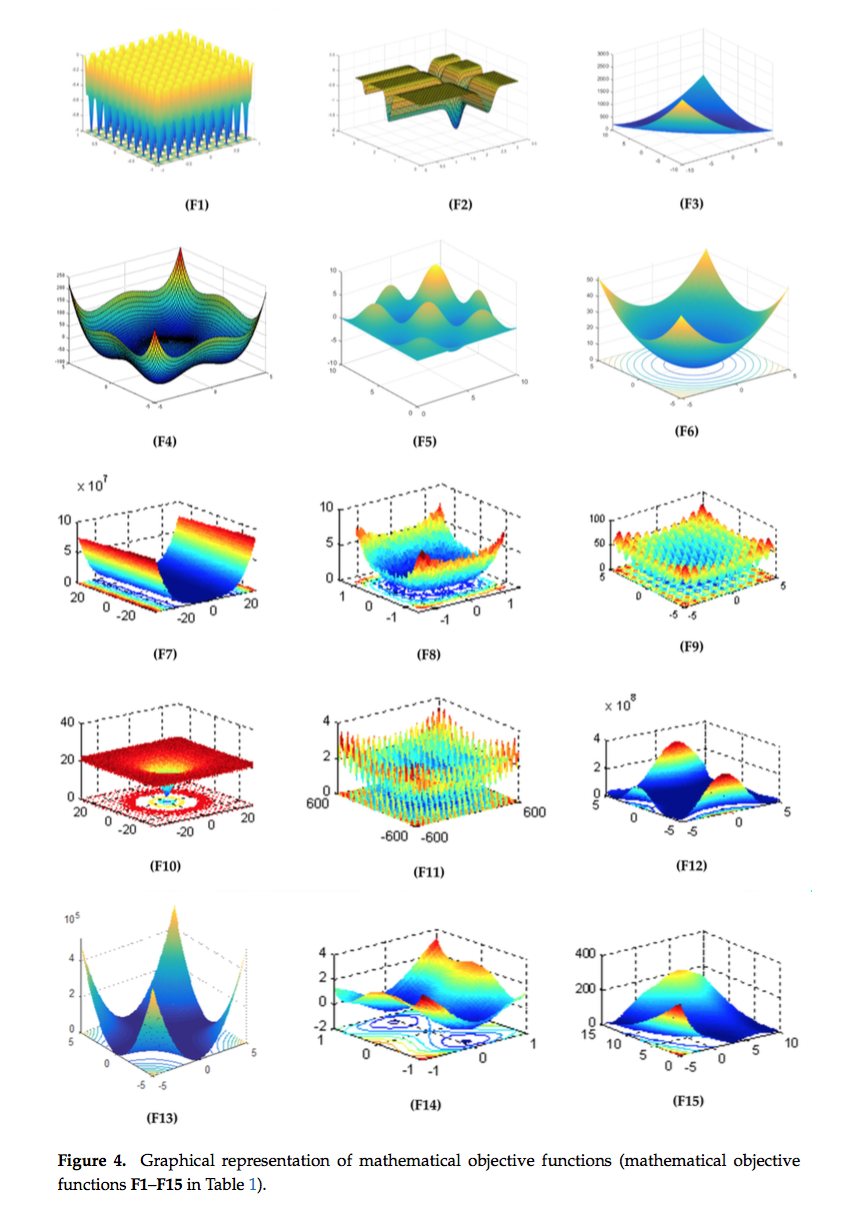

Figure 4 from GABONST

The values for ai and bi in the objective function 13 from the above figure were not mentioned and hence was not benchmarked.


### TSP Adaptation
#### Implementation
New crossover and mutation methods are implemented for TSP adaptation.

#### Crossover
Two points crossover is used in our implementation, where the sequence is taken between the crossover points from one chromosome, and the remaining chromosomes are filled in sequentially from the other chromosome.

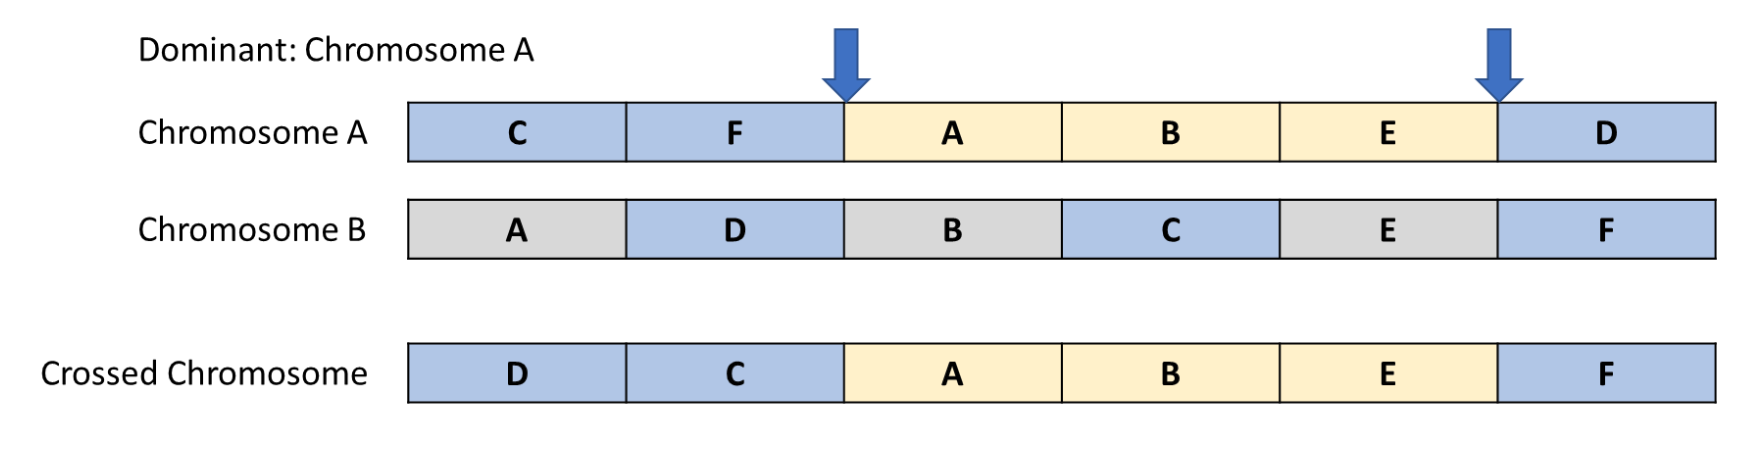

#### 2-opt Mutation
Two 2-opt mutation is used in our implementation, the operation flipps two edges in the tour.

### TSP Art Generation
#### Source Image
The source image of the 3D text is generated with the open source script \[3D Text\]

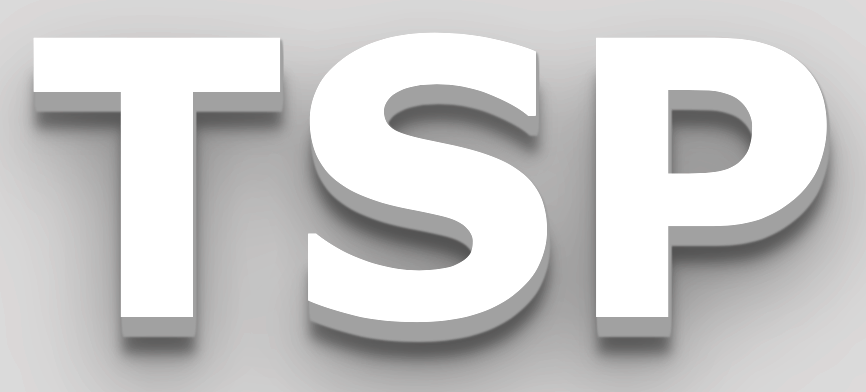

#### Dither and Vectorize
The image is then dithered with\[dither\]

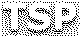

Then the image is converted into coordinates in text with the python script shown in appendix. The script is inspired by \[Image to coord\]. A uniform noise of \[-0.5, 0.5\] is then added to the coordinate to make the points look more organic.
#### Run Parameters
The coordinates are then fed through our GABONST implementation for TSP optimization. With the following parameters:\
\
570 Cities\
population = 600, Iterations = 50000\
Initialized with 570 nearest neighbor populations\

The generated TSP art is shown in the Results section.

## Results
### Real-Number Optimization


#### Tables of Stats

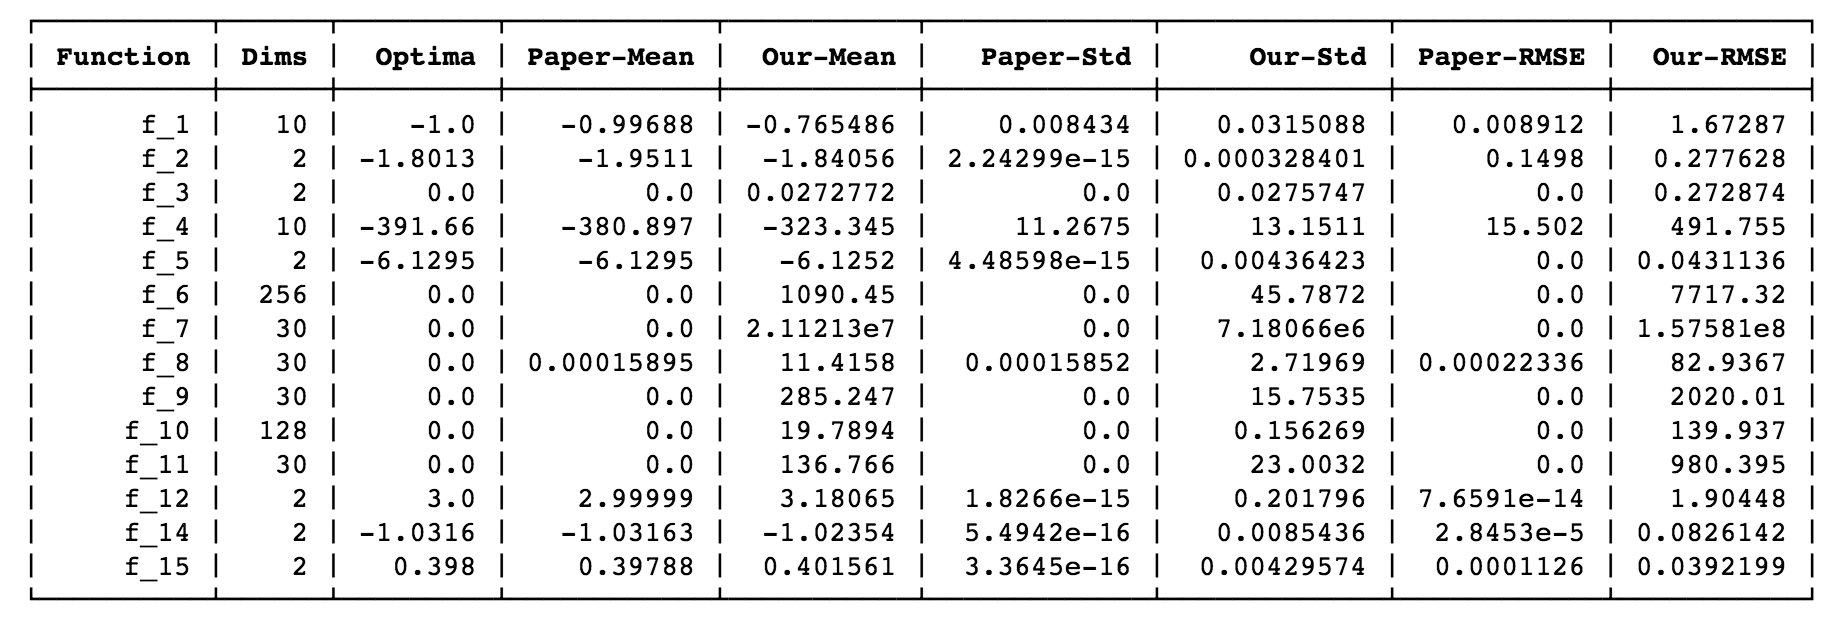

### TSP

#### Random Dataset

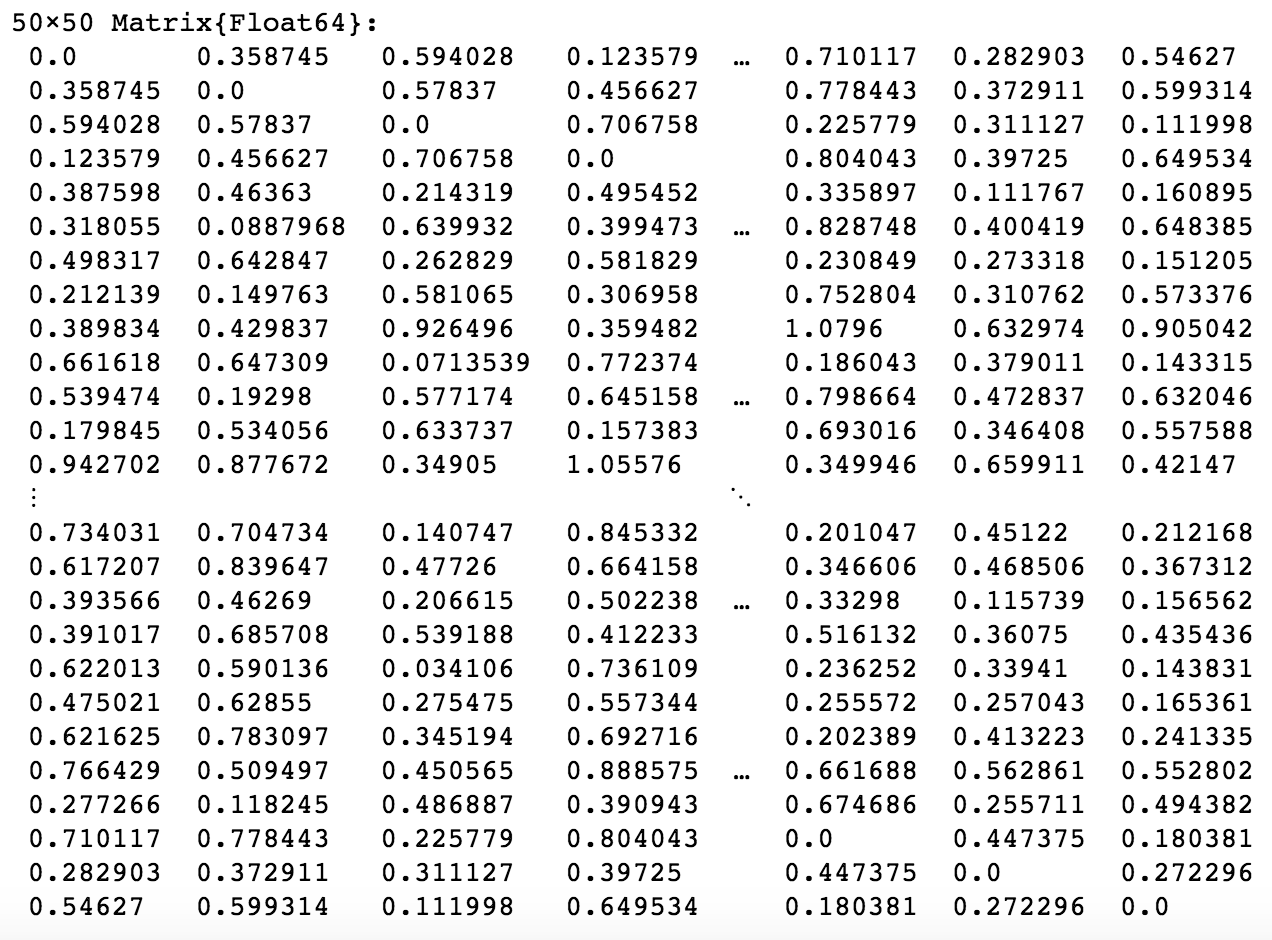

Results for Max Iteration = 30000, Population Size = 200, 2-Opt Mutation Rate = 1% Simulations = 20

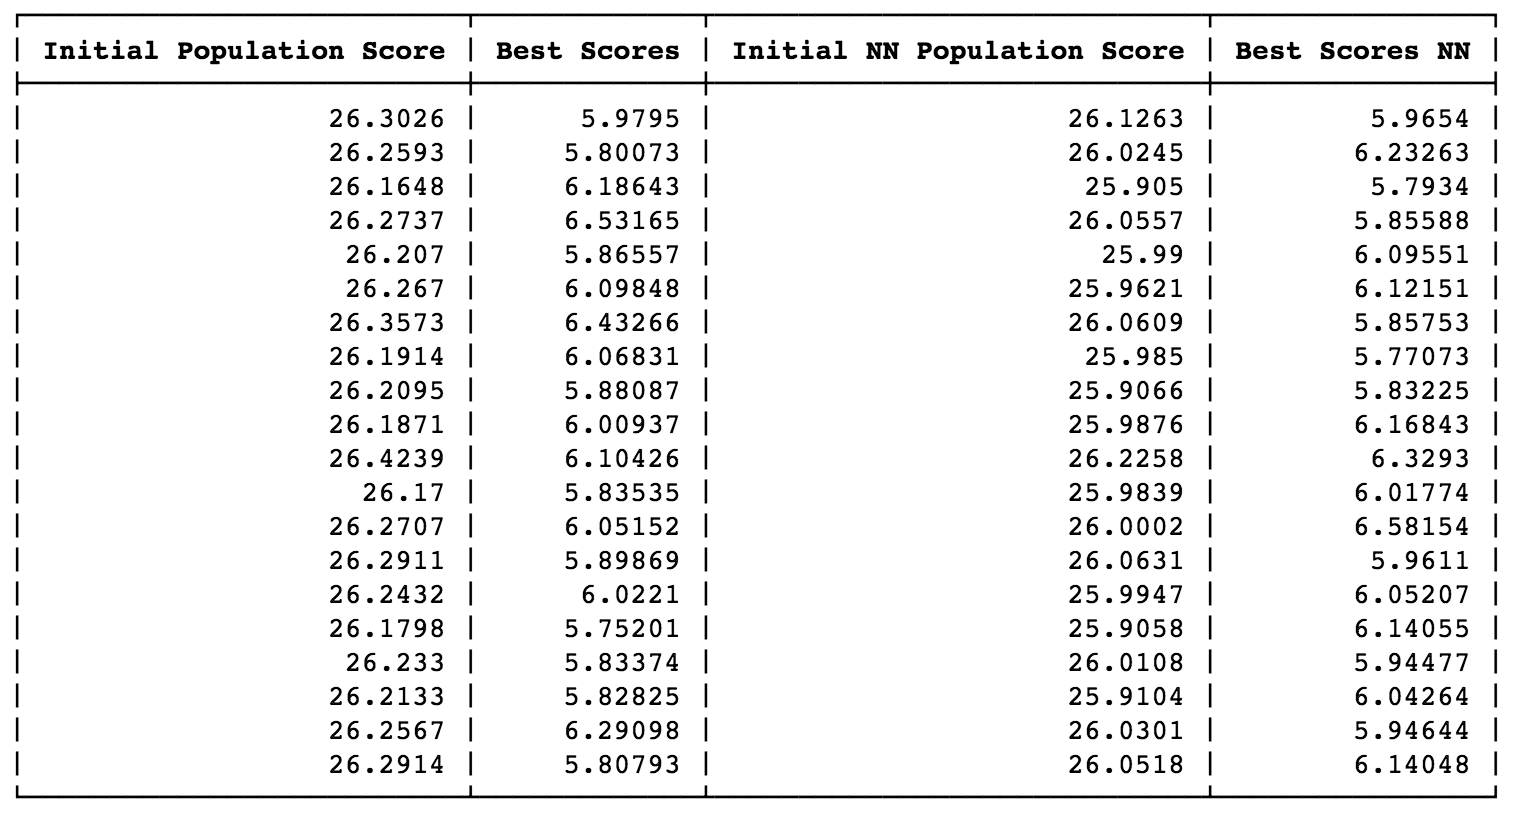

Results for Max Iteration = 50000, Population Size = 200, 2-Opt Mutation Rate = 1% Simulations = 20

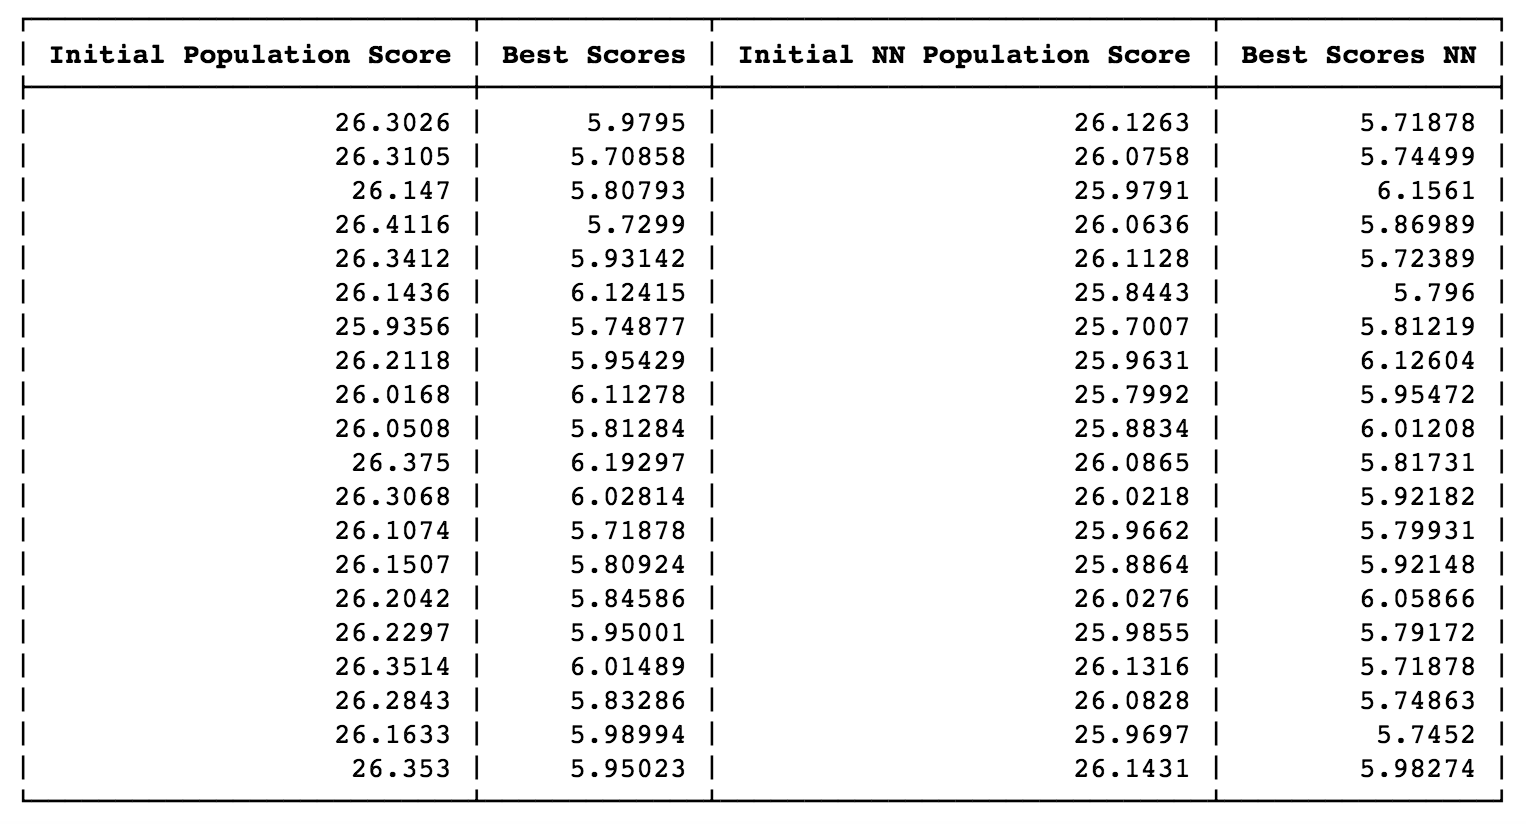

We Observe that GABONST converges comparably over a large enough number of iterations regardless of Nearest Neighbor solutions in the initial population. However, there are slight improvements in some cases when the number of iterations is increased which could suggest that GABONST does better when it is run for longer.

#### TSPlib Dataset

TSPLIB is a library of sample instances for the TSP (and related problems) from various sources and of various types. 
For the purposes of benchmarking we pick 5 instances, Berlin52, EIL51, CH130, LIN105 and KROA100.

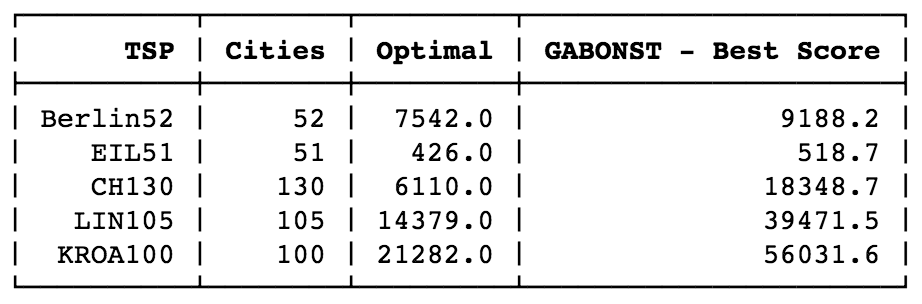

With Nearest Neighbour solutions in initial population

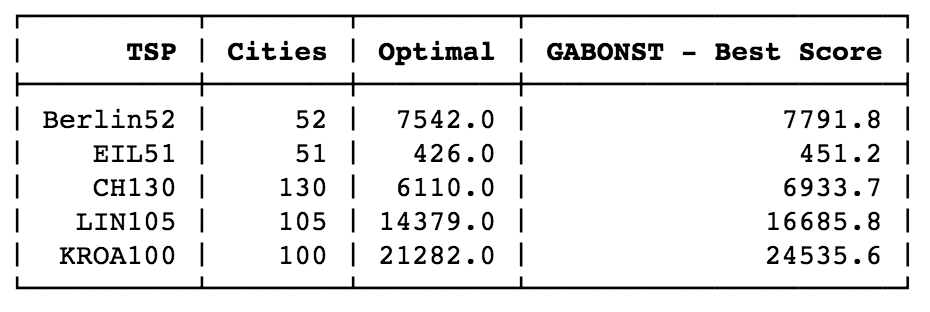

From simulations we observe that the GABONST algorithm works and produces performances close to the optimal when paired with the Nearest Neighbor algorithm to generate a few members of the initial population.  

### TSP Art

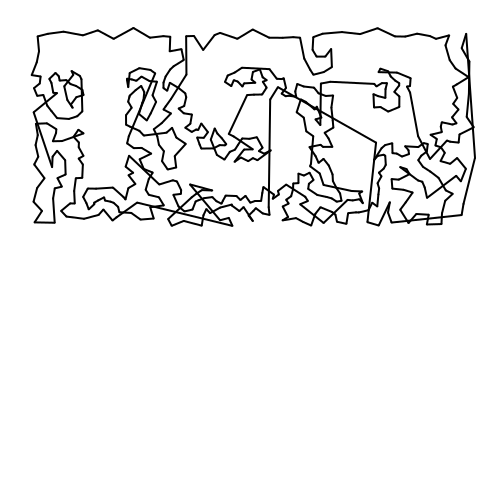

## Discussions
### Mismatch
We found mismatch between our implementation result and the published data from while benchmarking GABONST against 14/15 objective functions. We have tried our best to iron out bugs and potential errors in our implementation. We have tried to reach out to the authors for their matlab implementation, but we did't get their response at the time of writing. Interestingly ,we found a repository which we believe to be an independent implementation of GABONST in python. The result shown in that repository is surprisingly similar to our implementation, especially for the higher dimension problems. Upon furthur inspection to the published figures in the template paper, we found that many of the results shown for high dimension problems reaches 0 in upon initialization or in the first iteration. Which we reasonably doubt the probability of such event occur within the first 100 searches (2 iterations) high enough for their performance claim.
### Underperforming in High Dimension Problems
We observed that GABONST is not very effective when the dimension of the problem is high. This is clearly demonstrated in the optimization of the sphere function (F6) with 256 dimensions. GABONST is unable to get near to the optimal solution in our implementation. This could also be observed in TSP with high city count. Our adapted GABONST did not generate solutions that are crossing free in high city count examples.
### Lack of Elitism
Throughout our implementation and tuning of GABONST, we noticed that the population best does not always adhere to the global best in the convergence graph. This created some difficulty when we were trying to determine the mutation rate of the design. The best solution of the population will always be above average hence always go through the mutation process. This means we will increase the potential of destroying the best result with higher mutation rate. We believe the employment of elitism could resolve this shortcoming.
### Biodiversity
One of the benefit GABONST has is the replacement mechanism for underperforming individuals. This mechanism maintains the "biodiversity" of the population and preventing premature convergence. This means that if GABONST fails to find the optimal solution, it would at least have some random search feature to eventually find the solution.

## References

\[GABONST\] Albadr, Musatafa Abbas Abbood et al. “Genetic Algorithm Based on Natural Selection Theory for Optimization Problems.” Symmetry 12 (2020): 1758.\
\[TSPlib\] http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/ \
\[3D Text\] https://codepen.io/ryandsouza13/pen/yEBJQV \
\[Dither\] https://ditherit.com \
\[Image to  coord\] https://stackoverflow.com/questions/58398300/find-all-coordinates-of-black-grey-pixels-in-image-using-python

## Appendix
### Dithered png file to coordinates

In [ ]:

import cv2
import numpy as np
import sys

#print (sys.argv)

image = cv2.imread(sys.argv[1])
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Set threshold level
threshold_level = 1

# Find coordinates of all pixels below threshold
coords = np.column_stack(np.where(gray < threshold_level))

for coord in coords:
    print(coord[1], end=' ')
print()
for coord in coords:
    print(coord[0], end=' ')
print()

"""
print('[')
for coord in coords:
    print('[',end='')
    print(coord[0],end='')
    print(', ',end='')
    print(coord[1],end='')
    print('] ')
print(']')
"""
#print(coords)
print("Cities = ",len(coords))

# Create mask of all pixels lower than threshold level
#mask = gray < threshold_level

# Color the pixels in the mask
#image[mask] = (204, 119, 0)

#cv2.imshow('image', image)
#cv2.waitKey()
